# Big Data Project-1

### Yash Kasundra
### ID- a1838670

## Quora Insincere Questions Classification

### Description

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

Credits: Kaggle

__Problem Statement__

- Detect toxic content to improve online conversations.
- We have to develop models that identify and flag insincere questions.
- Source: https://www.kaggle.com/c/quora-insincere-questions-classification

#### Dataset can be Found on Kaggle using this link:  
https://www.kaggle.com/c/quora-insincere-questions-classification/data

Make Sure to keep train.csv and test.csv in same folder as this ipynb 

## This is the first part of this project

    - It Contains EDA
    - Preprocessing
    - Train Test split
    - Basic modles
    - Evaluation

## 1. Exploratory Data Analysis

#### Please use this commands if any of the below libraries are not installed on your pc/laptop

    !pip install wordcloud
    !pip install nltk
    !pip install spicy
    !pip install seaborn
    !pip install numpy
    !pip install pandas
    !pip install sklearn
    !pip install tensorflow

### 1.1 Loading python libraries

In [4]:
%matplotlib inline
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import re #regular expression to find special character sequence
import csv
import string
import gc # Garbage Collector
import shutil
import tensorflow as tf

import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
# WordCloud:- Cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word
from wordcloud import WordCloud, STOPWORDS
# To stack sparse matrices togather
from scipy.sparse import hstack

color = sns.color_palette()

# The Natural Language Toolkit, or more commonly NLTK, 
# is a suite of libraries and programs for symbolic and statistical natural language processing
from nltk.stem import  WordNetLemmatizer # PorterStemmer, SnowballStemmer,
# from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers


In [5]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1.2 Loading data and printing basic stats

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 375806


In [7]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


### 1.3 Checking if question_text contains any null or duplicate values, and check number of samples in each class

In [9]:
# Checking for null values in both train and test data.

df_train['question_text'].isnull().sum(), df_test['question_text'].isnull().sum() 

(0, 0)

No null values is present in this data set

In [10]:
# Now Check for any duplicate values

df_train.duplicated(subset={"question_text","qid","target"}).value_counts()

False    1306122
dtype: int64

No duplicate values have been found for all rows i.e. 1306122

In [11]:
print(df_train.shape,df_test.shape)

(1306122, 3) (375806, 2)


In [12]:
# Number of questions present in both classifications

sinc_num = len(df_train.question_text[df_train['target'] == 0]),'sincere questions'
insinc_num= len(df_train.question_text[df_train['target'] == 1]),'unsincere questions'

print(sinc_num)
print(insinc_num)

(1225312, 'sincere questions')
(80810, 'unsincere questions')


In [13]:
df_train.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


### 1.4 Checking few graphs to understand the data sets

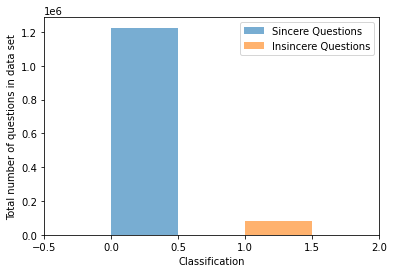

In [14]:
target_0 = df_train['target'][df_train['target'] == 0]
target_1 = df_train['target'][df_train['target'] == 1]

plt.hist(target_0,label='Sincere Questions',width = 0.5 ,alpha=0.6)
plt.hist(target_1,label='Insincere Questions',width = 0.5 ,alpha=0.6)

plt.xlim(-0.5, 2)
#these add labels and a legend
plt.xlabel('Classification')
plt.ylabel('Total number of questions in data set')
plt.legend()

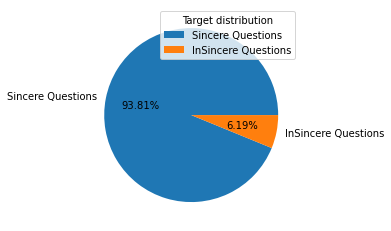

In [15]:
## target distribution ##
cnt_srs = df_train['target'].value_counts()
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))
mylabels = ["Sincere Questions", "InSincere Questions"]

plt.pie(cnt_srs, labels = mylabels , autopct = "%0.2f%%"  )
plt.legend(title = "Target distribution" , loc='upper right')
plt.show()

1) After seeing these graph we can see that data set is skewed towards sincere questions.

2) Dataset is highly imbalanced with only 6.2% of insincere questions.

3) F1-Score seems to be right choice than accuracy here because of data imbalance.

### 1.5 Word cloud for both sincere and insincere questions

Documentation for wordcloud library : https://amueller.github.io/word_cloud/

In [16]:
def wordcloud_display(text_data, title):

    # Taking all unique data and storing it in a list
    words_list = text_data.unique().tolist()
    # Joining all these words togather to into wordcloud function
    words = ' '.join(words_list)
    
    # To create a collage of words form input
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

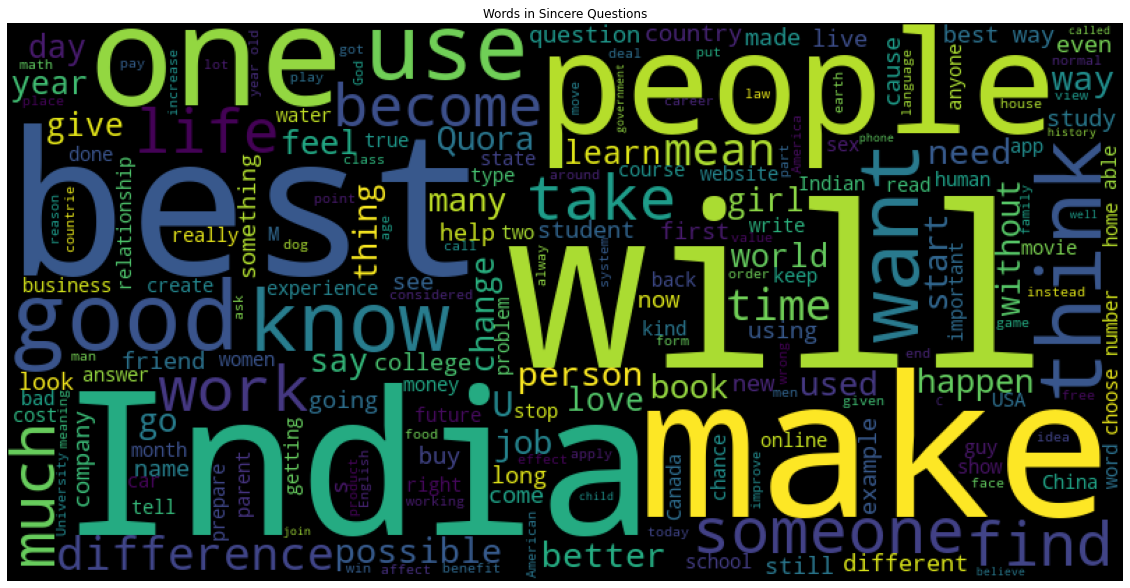

In [17]:
# Wordcloud for Sincere Questions
wordcloud_display(df_train[df_train['target']==0]['question_text'], 'Sincere Questions')

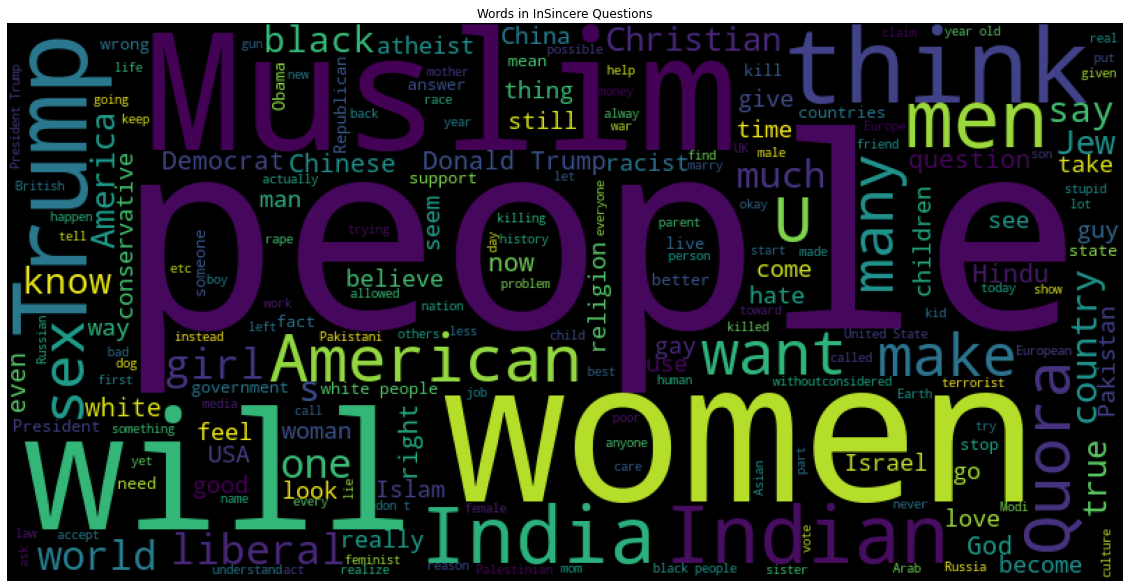

In [18]:
# Wordcloud for InSincere Questions
wordcloud_display(df_train[df_train['target']==1]['question_text'], 'InSincere Questions')

__Observations:__
- As we can see insincere questions contain many of the offensive words.
- Most of the questions are related to *People*, *Muslim*,  *Women*, *Trump*, *Sex*,*Liberal*,*Black*,*Racist* etc.
- There are few that overlaps in both sincere and insincere like *India*, *Christian*, *People*, *Make*, *One* etc but these classification can be know only after reading the whole questions.

### 1.6 Most Frequent words in both sincere and insincere questions (Unigrams (1 word ) | Bigrams (2 words) | Trigrams (3 words) )

Got the inspiration to use these frequency plot from:
https://www.tidytextmining.com/ngrams.html

In [19]:
def word_freq_plot(data, title, bar_color):
    
    # taking only 25 most used words 
    frequent_words = Counter(data).most_common(25)
    # Storing these words and their counts in a data frame and sorting these values based on their count
    df_words = pd.DataFrame(frequent_words, columns=['word', 'count']).sort_values('count')

    # Plotting a bar graph based on the data
    plt.barh(df_words['word'].values, df_words['count'].values, orientation='horizontal', color=bar_color) # plot
    plt.title(f'Top words in {title}')

__Stopwords:__
- Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc
- Thus we will be not considering those words

In [20]:
# Function to retrieve single words from question text
def get_unigrams(data):
    unigrams = []
    
    # Running a loop to separate/split the question text into single words and filtering stopwords
    for words in data:
        unigrams.extend([w for w in words.lower().split() if w not in STOPWORDS])
    return unigrams

# Function to retrieve pairs of 2 words from question text
def get_bigrams(data):
    bigrams = []
    
    # Running a loop to separate/split the question text into 2 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        bi = [b for b in nltk.bigrams(words)]
        bi = [' '.join(w) for w in bi]
        bigrams.extend(bi)
    return bigrams

# Function to retrieve pairs of 3 words from question text
def get_trigrams(data):
    trigrams = []
    
    # Running a loop to separate/split the question text into 3 words and filtering stopwords
    for words in data:
        words = [w for w in words.lower().split() if w not in STOPWORDS]
        tri = [t for t in nltk.trigrams(words)]
        tri = [' '.join(w) for w in tri]
        trigrams.extend(tri)
    return trigrams

In [21]:
# Creating data frames of unigram, bigram, trigram with sincere and insincere questions

# Unigrams
unigrams_sincere  = get_unigrams(df_train[df_train['target']==0]['question_text'])
unigrams_insincere = get_unigrams(df_train[df_train['target']==1]['question_text'])

# Bigrams
bigrams_sincere = get_bigrams(df_train[df_train['target']==0]['question_text'])
bigrams_insincere = get_bigrams(df_train[df_train['target']==1]['question_text'])

# Trigrams
trigrams_sincere = get_trigrams(df_train[df_train['target']==0]['question_text'])
trigrams_insincere = get_trigrams(df_train[df_train['target']==1]['question_text'])

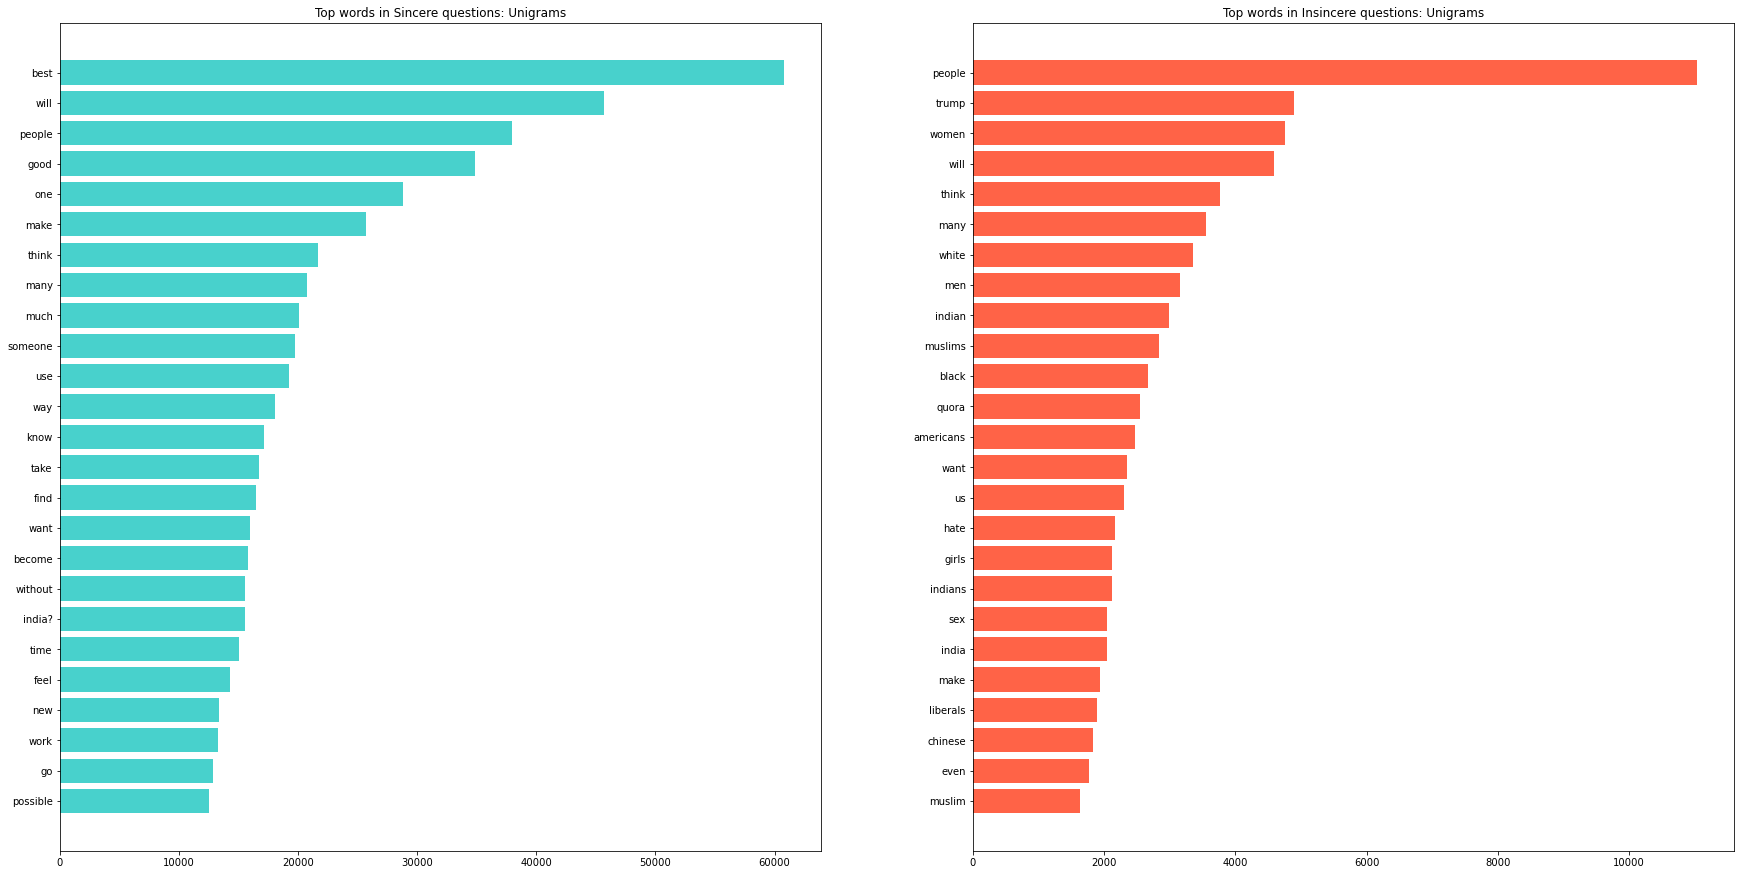

In [22]:
# plotting graph of Unigrams Sincere words 
plt.subplot(1, 2, 1)
word_freq_plot(unigrams_sincere, 'Sincere questions: Unigrams', 'mediumturquoise')

# plotting graph of Unigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(unigrams_insincere, 'Insincere questions: Unigrams', 'tomato')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

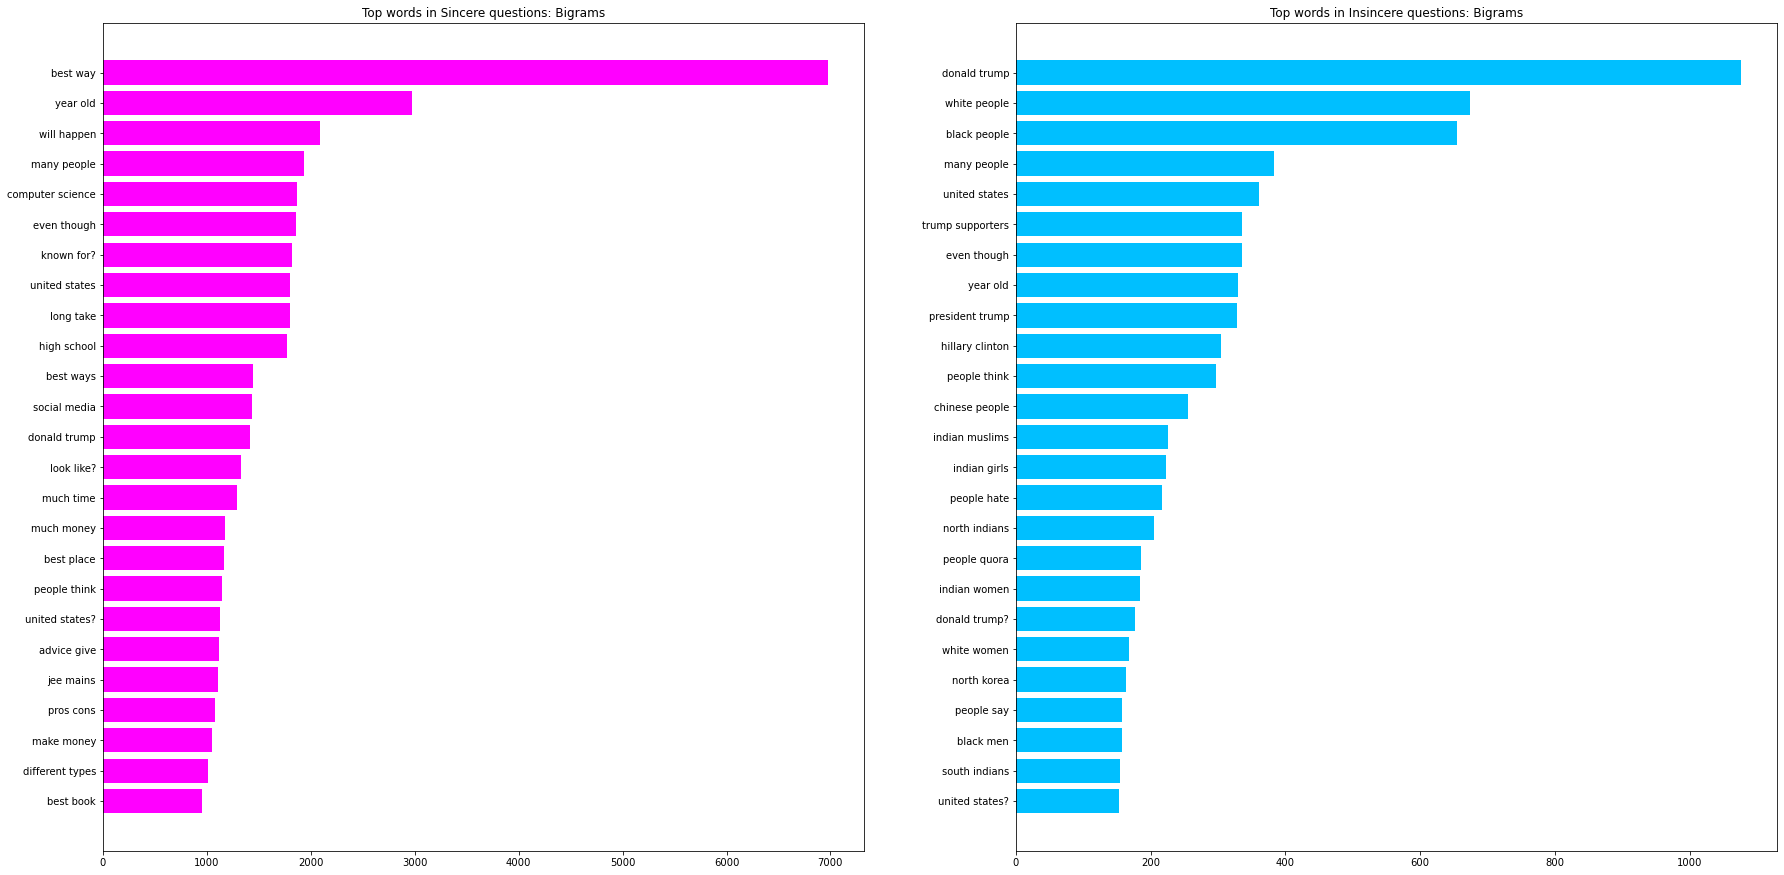

In [23]:
# plotting graph of Bigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(bigrams_sincere, 'Sincere questions: Bigrams', 'magenta')

# plotting graph of Bigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(bigrams_insincere, 'Insincere questions: Bigrams', 'deepskyblue')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

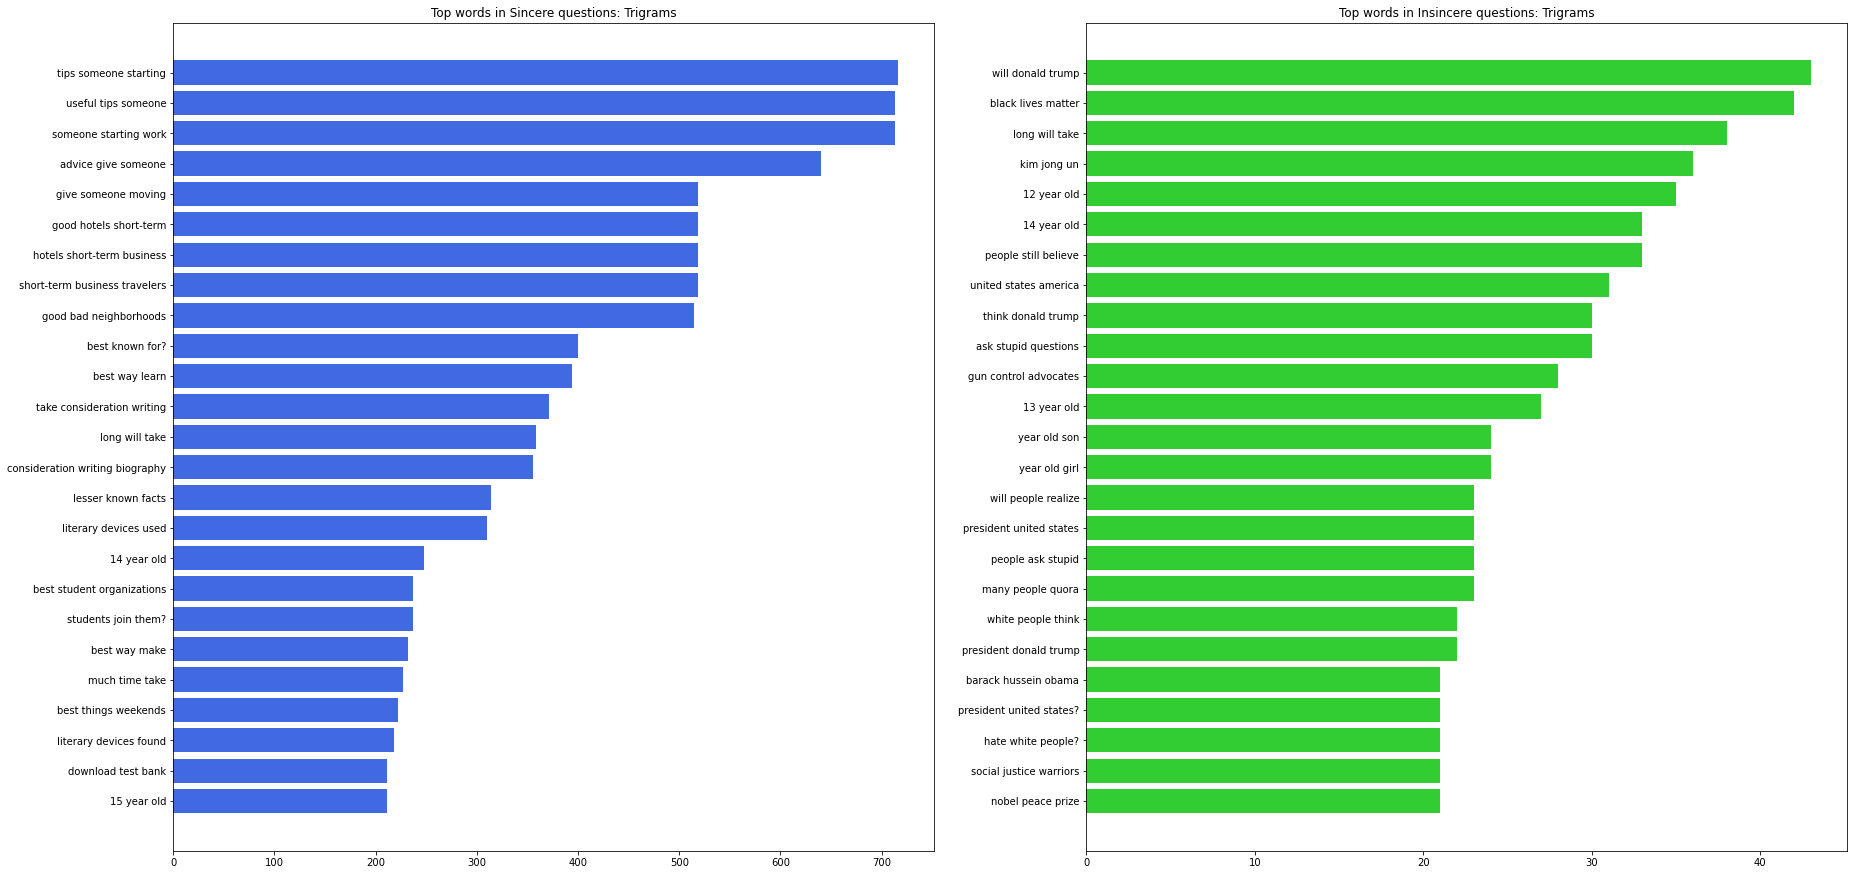

In [24]:
# plotting graph of Trigrams Sincere words
plt.subplot(1, 2, 1)
word_freq_plot(trigrams_sincere, 'Sincere questions: Trigrams', 'royalblue')

# plotting graph of Trigrams Insincere words
plt.subplot(1, 2, 2)
word_freq_plot(trigrams_insincere, 'Insincere questions: Trigrams', 'limegreen')
plt.subplots_adjust(right=4)
plt.subplots_adjust(top=3)
plt.show()

From above plots we have some ideas what the most used words, phrases are in both the classes.

### 1.7 Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Nu,mber of special characters
6. Number of punctuations
7. Number of upper case words
8. Number of title case words
9. Average length of the words

In [25]:
# Number of words in the text
df_train["words_count"] = df_train["question_text"].apply(lambda x: len(str(x).split()))
df_test["words_count"] = df_test["question_text"].apply(lambda x: len(str(x).split()))

# Number of unique words in the text
df_train["uniques_word_count"] = df_train["question_text"].apply(lambda x: len(set(str(x).split())))
df_test["uniques_word_count"] = df_test["question_text"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the text
df_train["chars_count"] = df_train["question_text"].apply(lambda x: len(str(x)))
df_test["chars_count"] = df_test["question_text"].apply(lambda x: len(str(x)))

# Number of stopwords in the text
df_train["stopword_count"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test["stopword_count"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# Number of numerics
df_train['numerics_count'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['numerics_count'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of punctuations in the text
df_train["punctuations_count"] =df_train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df_test["punctuations_count"] =df_test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Number of upper case words in the text
df_train["words_count_upper"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_test["words_count_upper"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of title case words in the text
df_train["words_count_title"] = df_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df_test["words_count_title"] = df_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Average length of the words in the text
df_train["mean_word_len"] = df_train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len"] = df_test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
df_train.head()

,qid,question_text,target,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,4,1,0,2,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,15,81,10,0,2,0,1,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,8,67,3,0,2,0,2,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,9,57,3,0,1,0,4,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,15,77,7,0,1,2,3,4.200000


In [27]:
df_test.head()

,qid,question_text,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,21,19,101,12,0,1,0,1,3.857143
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,30,23,162,17,0,2,6,5,4.433333
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,10,10,50,7,0,1,0,1,4.100000
3,000086e4b7e1c7146103,Who are entrepreneurs?,3,3,22,2,0,1,0,1,6.666667
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,7,7,48,1,0,1,0,1,6.000000


### 1.8 Now let us see how these meta features are distributed between both sincere and insincere questions.

And I'm truncating extreme values (outliers) i.e any value bigger than a set of values that I came up with, in order to get better visuals

In [28]:
# Making a function to plot boxplot, so I don't have to write same lines of code
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

In [29]:
# Making a function to plot boxplot, so I don't have to write same lines of code
def display_violinplot(_x, _y, _data, _title):
    sns.violinplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

In [30]:
df_train['words_count'].loc[df_train['words_count']>60] = 60
df_train['uniques_word_count'].loc[df_train['uniques_word_count']>50] = 50
df_train['chars_count'].loc[df_train['chars_count']>400] = 400
df_train['stopword_count'].loc[df_train['stopword_count']>30] = 30
df_train['numerics_count'].loc[df_train['numerics_count']>75] = 75
df_train['punctuations_count'].loc[df_train['punctuations_count']>100] = 100
df_train['words_count_upper'].loc[df_train['words_count_upper']>15] = 15
df_train['words_count_title'].loc[df_train['words_count_title']>15] = 15
df_train['mean_word_len'].loc[df_train['mean_word_len']>20] = 20

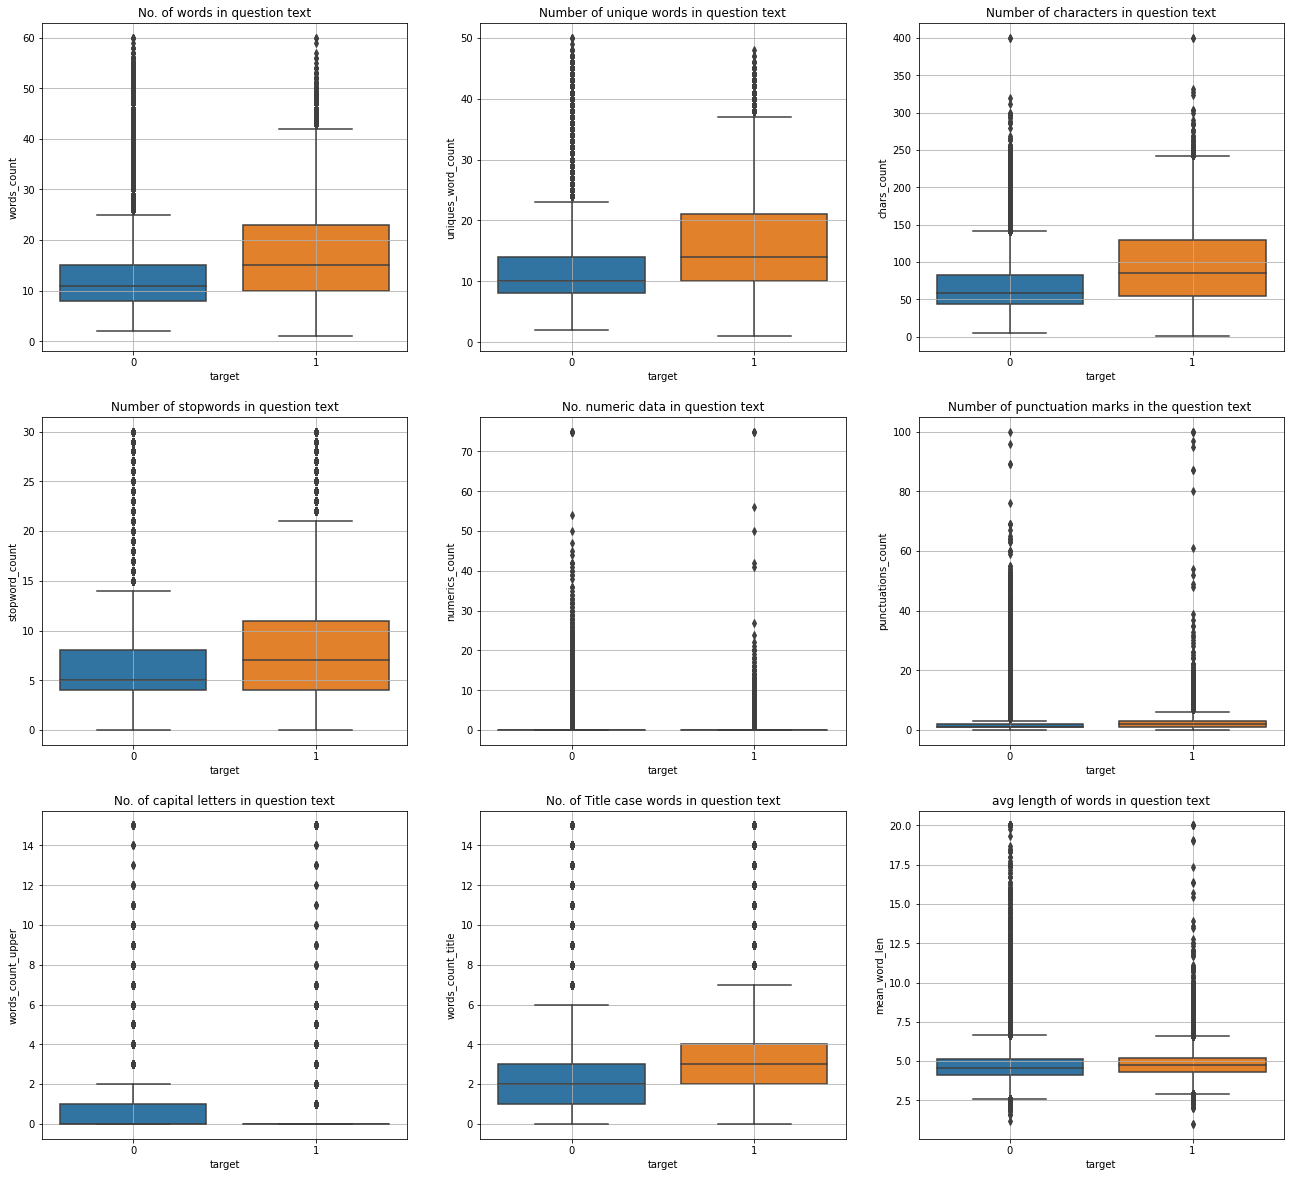

In [31]:
# Boxplot: Number of words
plt.subplot(3, 3, 1)
display_boxplot('target', 'words_count', df_train, 'No. of words in question text')

# Boxplot: Number of unique words
plt.subplot(3, 3, 2)
display_boxplot('target', 'uniques_word_count', df_train, 'Number of unique words in question text')

# Boxplot: Number of chars
plt.subplot(3, 3, 3)
display_boxplot('target', 'chars_count', df_train, 'Number of characters in question text')

# Boxplot: Number of stopwords
plt.subplot(3, 3, 4)
display_boxplot('target', 'stopword_count', df_train, 'Number of stopwords in question text')

# Boxplot: Number of numerics
plt.subplot(3, 3, 5)
display_boxplot('target', 'numerics_count', df_train, 'No. numeric data in question text')

# Boxplot: Number of punctuations
plt.subplot(3, 3, 6)
display_boxplot('target', 'punctuations_count', df_train, 'Number of punctuation marks in the question text ')

# Boxplot: Number of capital letters
plt.subplot(3, 3, 7)
display_boxplot('target', 'words_count_upper', df_train, 'No. of capital letters in question text')

# Boxplot: Number of title case words
plt.subplot(3, 3, 8)
display_boxplot('target', 'words_count_title', df_train, 'No. of Title case words in question text')

# Boxplot: Average length of words
plt.subplot(3, 3, 9)
display_boxplot('target', 'mean_word_len', df_train, 'avg length of words in question text')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=4.0)
plt.show()

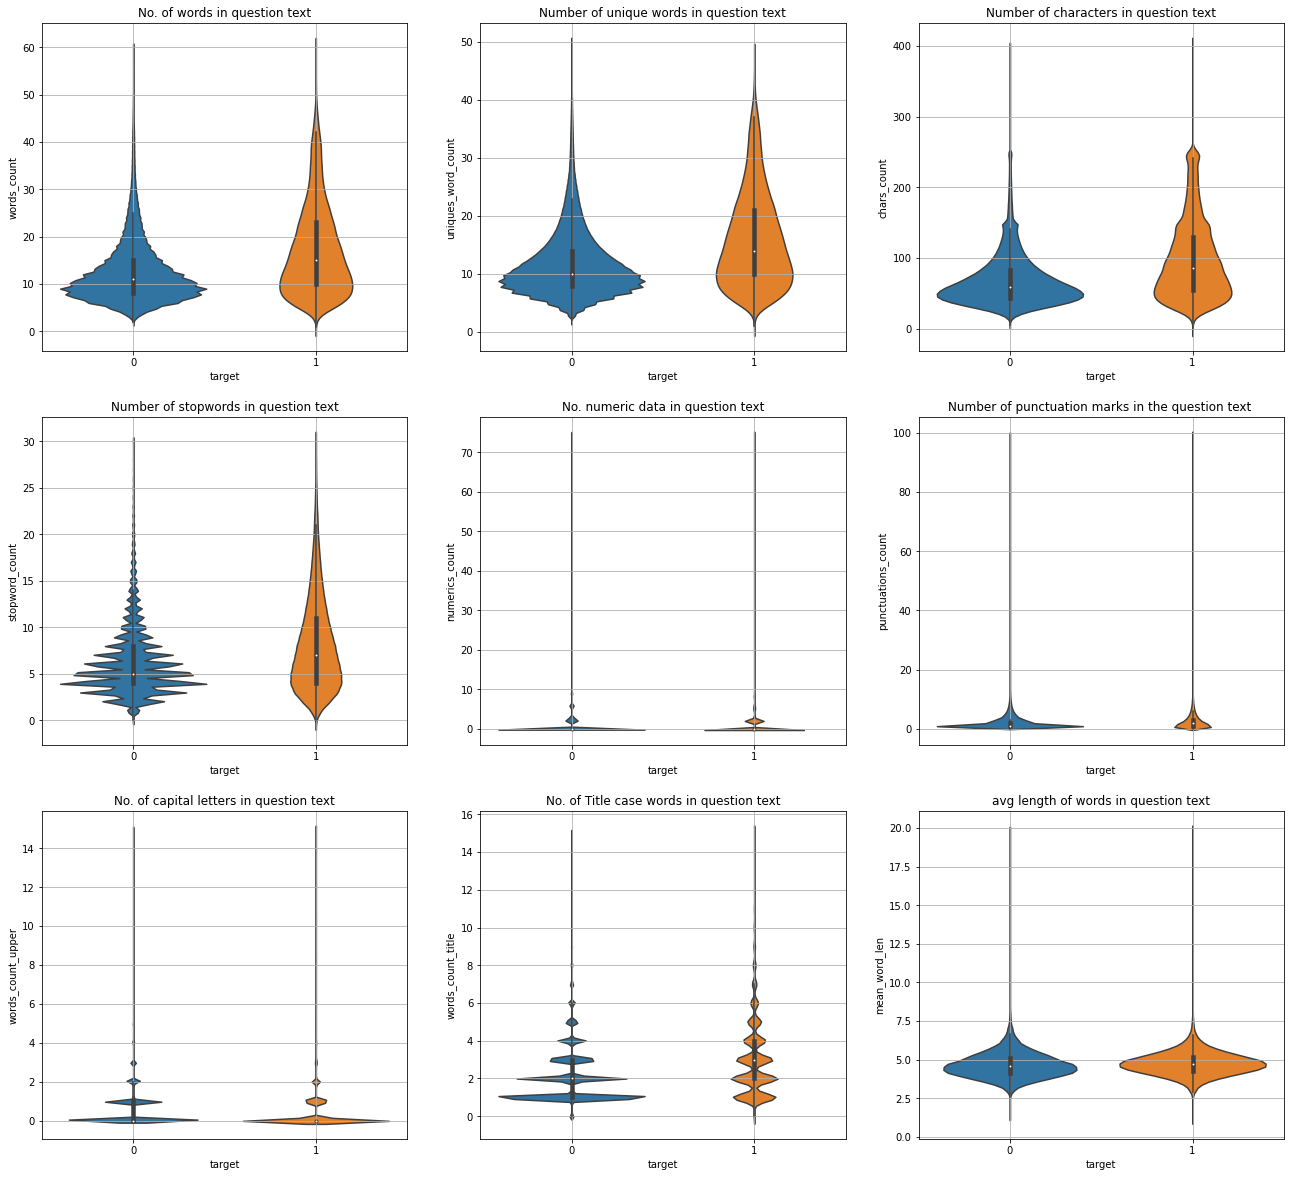

In [32]:
# violinplot: Number of words
plt.subplot(3, 3, 1)
display_violinplot('target', 'words_count', df_train, 'No. of words in question text')

# violinplot: Number of unique words
plt.subplot(3, 3, 2)
display_violinplot('target', 'uniques_word_count', df_train, 'Number of unique words in question text')

# violinplot: Number of chars
plt.subplot(3, 3, 3)
display_violinplot('target', 'chars_count', df_train, 'Number of characters in question text')

# violinplot: Number of stopwords
plt.subplot(3, 3, 4)
display_violinplot('target', 'stopword_count', df_train, 'Number of stopwords in question text')

# violinplot: Number of numerics
plt.subplot(3, 3, 5)
display_violinplot('target', 'numerics_count', df_train, 'No. numeric data in question text')

# violinplot: Number of punctuations
plt.subplot(3, 3, 6)
display_violinplot('target', 'punctuations_count', df_train, 'Number of punctuation marks in the question text ')

# violinplot: Number of capital letters
plt.subplot(3, 3, 7)
display_violinplot('target', 'words_count_upper', df_train, 'No. of capital letters in question text')

# violinplot: Number of title case words
plt.subplot(3, 3, 8)
display_violinplot('target', 'words_count_title', df_train, 'No. of Title case words in question text')

# violinplot: Average length of words
plt.subplot(3, 3, 9)
display_violinplot('target', 'mean_word_len', df_train, 'avg length of words in question text')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=4.0)
plt.show()

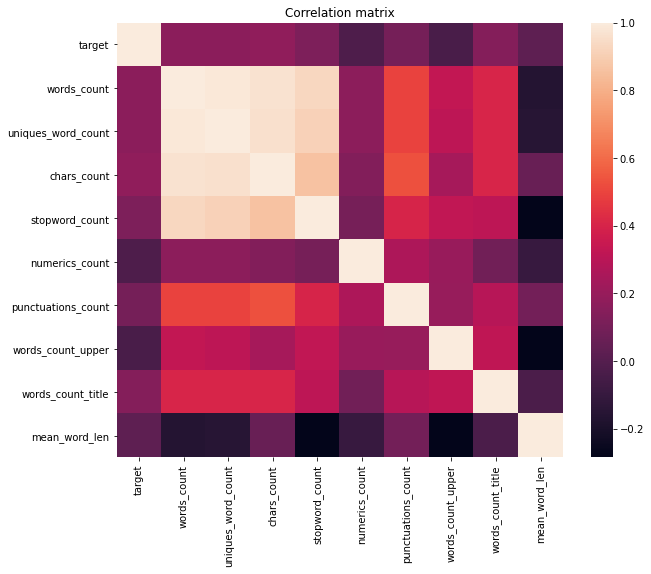

In [33]:
# plotting Correlation matrix for training data with those meta features
f, ax = plt.subplots(figsize=(10, 8))
corr = df_train.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

__Observations__
- Insincere questions seems to have more words and characters.
- Insincere questions also have more unique words compare to sincere questions.

### 1.9 From above observation lets see few questions with most punctuation marks

Insincere questions will be printed in red and sincere will be black.

In [34]:
# Questions with most number of non-alphanumeric characters.
  # Insincere questions are printed in red color.

# sorting using punctuation count and then taking qids of first 10 questions with most symbols
qids = df_train.sort_values('punctuations_count', ascending=False)['qid'].head(10).values

# Running a for loop to check all those values
for id in qids:
    
    row = df_train[df_train['qid'].values == id]
    # Checking if the target is sincere or not and then print them in different colors
    if row['target'].values[0] == 1: 
        color = '\033[31m'
    else:
        color = '\033[0m'
    print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

Now lets check how many different types of punctuation marks are there in the data set

In [35]:
# Returns a set with all symbols used in questions asked on quora data set
def retrieve_symbol(data):
    """
    Returns SET: special symbols in corpus
    """
    # Initializing empty set/array to store values
    symbols = []
    for text in data:
        # Using Regular expression library getting all special characters from question texts
        s = re.findall(r'\W+', str(text))
        # Then appending all such special chars to our set/array
        symbols.extend(s), 
        
    return set(symbols)

In [36]:
spec_chars = retrieve_symbol(df_train['question_text'].values)
print(spec_chars)

{' *(', '〗^', ')] / [', ') | ', '(', ' (#) ', ',"? (', ' \u200b% ', '! }?', '] {\\ ', '}})}', ". '", '.}}))}^{', '! + ', '/ ?', '/. ', '? -- ', ' +∞?', '++ * ++', '}}}=', ' -√', '] (', '-” ', '-√ (', '° =?', '..........?', ' $$', ': ', '… "', ') >', ' # (', '≱', ') ×+', 'ा-', '?", "', '*|', '.)).', '? :/', '? :>', 'ा', '=? ', '*…* (', ')]-?', ' ()?', '++.', ',“', ' [^\\', '{[\\', '. :(', '(.', ' (+ ', '?”. ', '.”?', '({\\', ' & -', "©'", ' ∞ = ∞ + ', '？" ', '्)?', '-?', ')}?', ' ; (', '! :-', ' ("', '*. ', ') >-', ')-( (', '] ?', '))},', '.)?', '{(\\', '++ * ', '{"', ' %', '▒〖(-', ' ++', " '?' ", '? :-)', ': ? ', '() %', '≠ -', "! ' ", ' ":= " (', ' =.', '}}}}', ' √', ' * (', ') * \\', ' #*$& ', ' ", ', ' \\; ', '}-(', "…'?", ' = {(', '| < \\', '} ) } + \\', ' /* */ ', ' "@', ';)', ') ^ {-', ' * ', '))=', ' (~', '^++?', ': … ', ' :/', ' -?', '÷✓', '))/', '. .. ', ' | ^', ' ∈', '). ( ', "; ' ", "'), ", '^(', '= [(', ' + [', '))..', ' ("*-', ': $ \\', ' , -', ')) +', '+......}}} [/', ' =

__Observations:__
- Looks like there are some math questions(most of them are classified as insincere) in the data which contains more special chars and numbers.
- Some questions also contains emojis and non-english characters.

## 2. Data Preprocessing and cleaning

- Replacing math equations and url's with common abbrevation.
- Cleaning contractions.
- Spelling Correction.
- Removing punctuations.
- Removing Stopwords.
- Using WordNet Lemmatizer

### 2.1 Creating different functions to do above mentioned steps

Function to Replace math equations and url addresses with text.

https://www.kaggle.com/canming/ensemble-mean-iii-64-36

In [37]:

def clean_data(text_data):
    
    # Check if any maths formulas are present in the data
    if '[math]' in text_data:
        
        # Then changing that to a tag "MATH EQUATION" using regular etext_datapression library
        # So that our model can process our tetext_datat better and get increased accuracy
        text_data = re.sub('\[math\].*?math\]', 'MATH EQUATION', text_data)
        
    # Check if any urls are present in the data
    if 'http' in text_data or 'www' in text_data:
        
        # Then changing those to a tag "URL" using regular etext_datapression library
        text_data = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', text_data)
    return text_data

Function to clean Punctuation marks as well as emojis and symbols

https://www.kaggle.com/canming/ensemble-mean-iii-64-36

In [38]:


puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

# deleting punctuation marks or special characters from our tetext_datat data
def clear_punct(text_data):
    # Etext_dataplicit type casting to string
    text_data = str(text_data)
    
    # Running a loop to check if the data contains and special characters defined above in puncts 
    for punct in puncts:
        # If any of those are found then replace it with space 
        if punct in text_data:
            text_data = text_data.replace(punct, ' ')
    return text_data

Function to correct mispells

https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

In [39]:


mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 
                'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', 
                "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', 
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

# Correcting Mispelling, as not all of quora's user have english as first language thus they might make mistakes while asking questions
def correct_mispell(x):
    # Splitting the question text into words 
    words = x.split()
    # Running a loop to cover all words
    for i in range(0, len(words)):
        
        # First check if the word is present in above dictionary
        if mispell_dict.get(words[i]) is not None:
            # If it found then change that incorrect word to correct one from dictionary
            words[i] = mispell_dict.get(words[i])
            
        # It maybe the case that few letters are caps in the word, so we change to lower case then check in dictionary again
        # We didn't change them to lower at the start to save computing power
        elif mispell_dict.get(words[i].lower()) is not None:
            # If it found then change that incorrect word to correct one from dictionary
            words[i] = mispell_dict.get(words[i].lower())
            
    words = " ".join(words)
    return words

Function to remove stopwords

In [40]:

# As explained in above slides Stopwords are frequent words like of,a,an,the etc which doesn't add too much value when training our models
def remove_stopwords(x):
    
    # Split the question text into words and then check if that word is a stopword by comparing with all values in STOPWORDS set
    x = [word for word in x.split() if word not in STOPWORDS]
    x = ' '.join(x)

    return x

Function to clean word contractions

https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

In [41]:


contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", 
                       "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", 
                       "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", 
                       "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all",
                       "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", 
                       "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", 
                       "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", 
                       "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", 
                       "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", 
                       "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", 
                       "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are",
                       "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not",
                       "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are",
                       "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", 
                       "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", 
                       "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", 
                       "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not",
                       "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

#### LEMMATIZATION :-
We try to reduce a given word to its root word. The root word is called lemma in the lemmatization process. The algorithms have the Knowledge about the meaning of the word in the language

In [42]:
# word lemmatizing

word_lemma = WordNetLemmatizer()
def text_lemmatize(x):
    x = x.split()
    x = [word_lemma.lemmatize(word) for word in x]
    x = ' '.join(x)
    
    return x

In [43]:
def data_cleaning(x):
    x = clean_data(x)
    x = clear_punct(x)
    x = correct_mispell(x)
    x = remove_stopwords(x)
    x = clean_contractions(x)
    x = text_lemmatize(x)
    return x

In [44]:
# preprocessing given train and test data and storing it in other column
df_train['preprocessed_question_text'] = df_train['question_text'].apply(lambda x: data_cleaning(x))
df_test['preprocessed_question_text'] = df_test['question_text'].apply(lambda x: data_cleaning(x))

### 2.2 Checking few data from train and test datasets

In [45]:
df_train.head(1)

,qid,question_text,target,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,4,1,0,2,4.615385,How Quebec nationalist see province nation 1960s


In [46]:
df_test.tail(1)

,qid,question_text,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
375805,fffff85473f4699474b0,Climate change is a worrying topic. How much t...,36,33,189,16,4,7,2,5,4.277778,Climate change worrying topic How much time le...


In [47]:
sincere=df_train[df_train['target']==0]
insincere=df_train[df_train['target']==1]

In [48]:
sincere.head(1)

,qid,question_text,target,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,4,1,0,2,4.615385,How Quebec nationalist see province nation 1960s


In [49]:
insincere.head(1)

,qid,question_text,target,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,11,9,67,5,0,1,0,3,5.181818,Has United States become largest dictatorship ...


#### Creating few columns based on preprocessed questions to visualize the data

In [50]:
# Number of words in the preprocessed question text
df_train["words_count_preprocessed"] = df_train["preprocessed_question_text"].apply(lambda x: len(str(x).split()))
df_test["words_count_preprocessed"] = df_test["preprocessed_question_text"].apply(lambda x: len(str(x).split()))

# Number of unique words in the preprocessed question text
df_train["uniques_words_preprocessed"] = df_train["preprocessed_question_text"].apply(lambda x: len(set(str(x).split())))
df_test["uniques_word_preprocessed"] = df_test["preprocessed_question_text"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the preprocessed question text
df_train["chars_count_preprocessed"] = df_train["preprocessed_question_text"].apply(lambda x: len(str(x)))
df_test["chars_count_preprocessed"] = df_test["preprocessed_question_text"].apply(lambda x: len(str(x)))

# Average length of the words in the preprocessed question text
df_train["mean_word_len_preprocessed"] = df_train["preprocessed_question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len_preprocessed"] = df_test["preprocessed_question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


### 2.3 Visualization after cleaning the data

#### 2.3.1 Boxplots:-

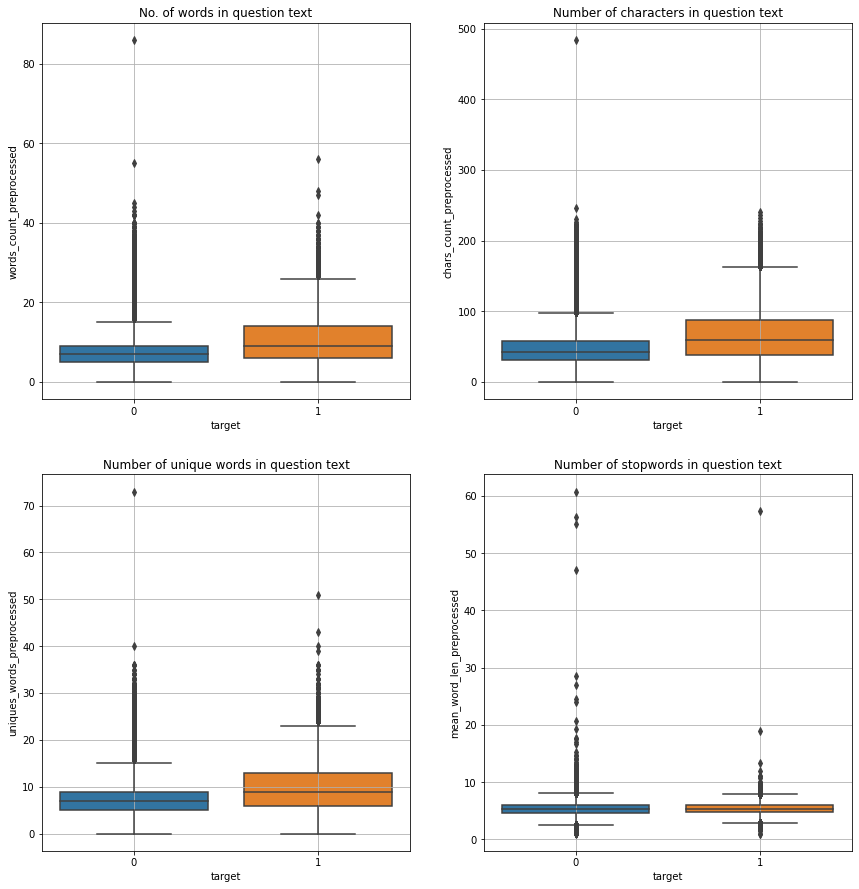

In [51]:
# Calling function display_boxplot to plot boxplots for newly created columns

# Boxplot: Number of words
plt.subplot(2, 2, 1)
display_boxplot('target', 'words_count_preprocessed', df_train, 'No. of words in question text')

# Boxplot: Number of chars
plt.subplot(2, 2, 2)
display_boxplot('target', 'chars_count_preprocessed', df_train, 'Number of characters in question text')

# Boxplot: Number of unique words
plt.subplot(2, 2, 3)
display_boxplot('target', 'uniques_words_preprocessed', df_train, 'Number of unique words in question text')

# Boxplot: Number of stopwords
plt.subplot(2, 2, 4)
display_boxplot('target', 'mean_word_len_preprocessed', df_train, 'Number of stopwords in question text')

plt.subplots_adjust(right=2.0)
plt.subplots_adjust(top=3.0)
plt.show()

#### 2.3.2 Violinplots:-

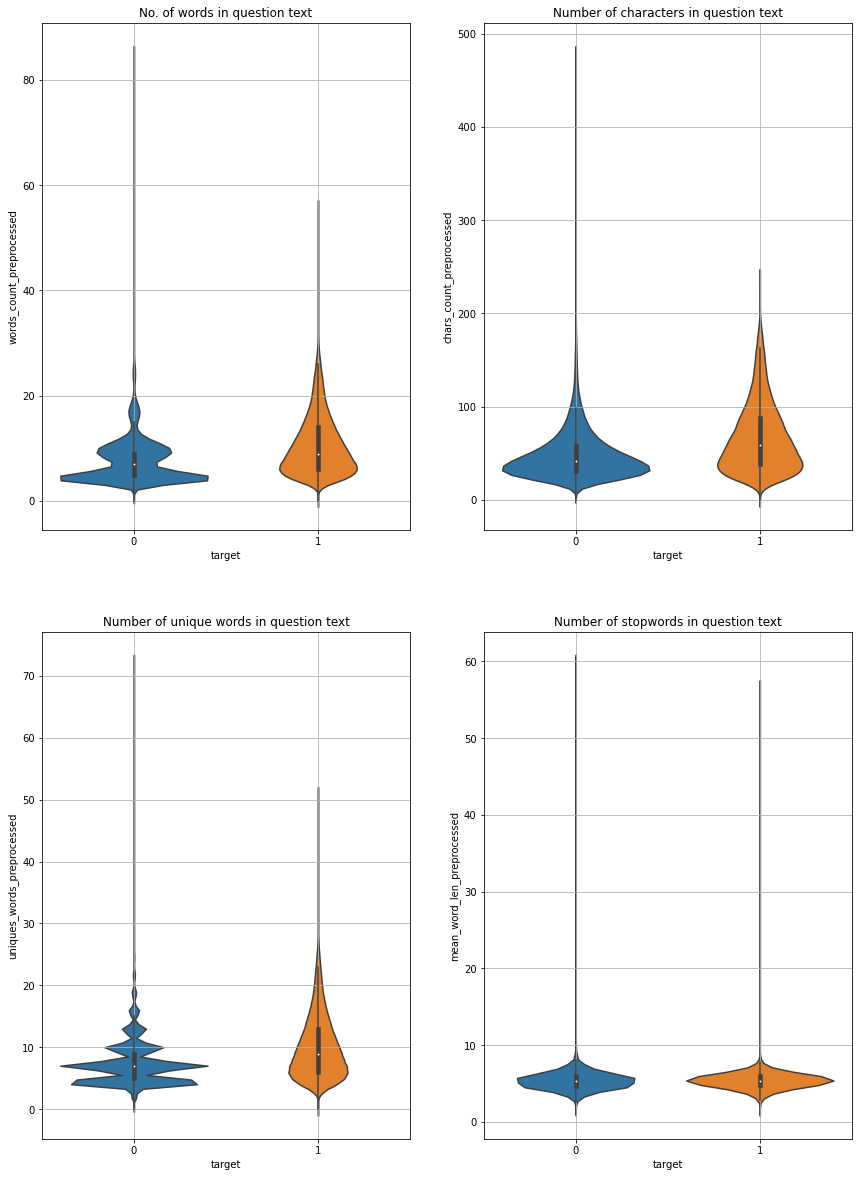

In [52]:
# Calling function display_boxplot to plot Violinplots for newly created columns

# violinplot: Number of words
plt.subplot(2, 2, 1)
display_violinplot('target', 'words_count_preprocessed', df_train, 'No. of words in question text')

# violinplot: Number of chars
plt.subplot(2, 2, 2)
display_violinplot('target', 'chars_count_preprocessed', df_train, 'Number of characters in question text')

# violinplot: Number of unique words
plt.subplot(2, 2, 3)
display_violinplot('target', 'uniques_words_preprocessed', df_train, 'Number of unique words in question text')

# violinplot: Number of stopwords
plt.subplot(2, 2, 4)
display_violinplot('target', 'mean_word_len_preprocessed', df_train, 'Number of stopwords in question text')

plt.subplots_adjust(right=2.0)
plt.subplots_adjust(top=4.0)
plt.show()

#### 2.3.3 Distplot:-

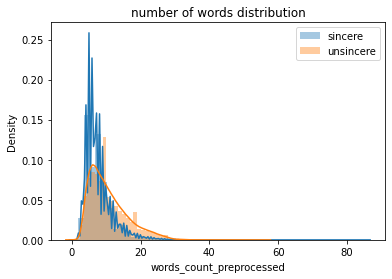

In [53]:
# Number of words in pre processed data

s1 = df_train[df_train['target'] == 0]['words_count_preprocessed']
sns.distplot(s1, label='sincere')
s2 = df_train[df_train['target'] == 1]['words_count_preprocessed']
sns.distplot(s2, label='unsincere')
plt.title('number of words distribution')
plt.legend();

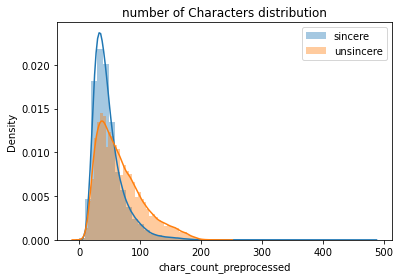

In [54]:
# Number of chars in pre processed data

s1 = df_train[df_train['target'] == 0]['chars_count_preprocessed']
sns.distplot(s1, label='sincere')
s2 = df_train[df_train['target'] == 1]['chars_count_preprocessed']
sns.distplot(s2, label='unsincere')
plt.title('number of Characters distribution')
plt.legend();

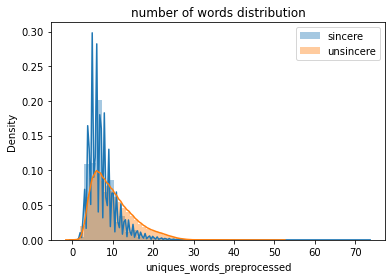

In [55]:
#number of unique words in pre processed df_train

s1 = df_train[df_train['target'] == 0]['uniques_words_preprocessed']
sns.distplot(s1, label='sincere')
s2 = df_train[df_train['target'] == 1]['uniques_words_preprocessed']
sns.distplot(s2, label='unsincere')
plt.title('number of words distribution')
plt.legend();

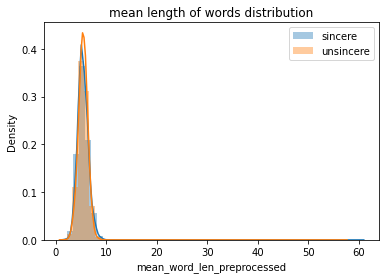

In [56]:
# mean length of a word from pre processed data

s1 = df_train[df_train['target'] == 0]['mean_word_len_preprocessed']
sns.distplot(s1, label='sincere')
s2 = df_train[df_train['target'] == 1]['mean_word_len_preprocessed']
sns.distplot(s2, label='unsincere')
plt.title('mean length of words distribution')
plt.legend();

### Dropping those above created columns for visualization

In [57]:
df_train = df_train.drop(['words_count_preprocessed','chars_count_preprocessed','uniques_words_preprocessed',
                          'mean_word_len_preprocessed'],axis = 1)
df_test = df_test.drop(['words_count_preprocessed','chars_count_preprocessed','uniques_word_preprocessed',
                        'mean_word_len_preprocessed'],axis = 1)


In [58]:
df_train.head(1)

,qid,question_text,target,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,13,72,7,4,1,0,2,4.615385,How Quebec nationalist see province nation 1960s


In [59]:
df_test.head(1)



,qid,question_text,words_count,uniques_word_count,chars_count,stopword_count,numerics_count,punctuations_count,words_count_upper,words_count_title,mean_word_len,preprocessed_question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,21,19,101,12,0,1,0,1,3.857143,Why many woman become rude arrogant little bit...


## 3. Model Creation and tuning

### 3.1 Train, Test & Validation split

In [60]:
# First storing those target values in a variable
y = df_train['target'].values

# Splitting the train dataset first in 80-20 split for train & test and then splitting that 80 into 90-10 split for validation
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2019)

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ',X_test.shape, y_test.shape)
print('X_val: ',X_val.shape, y_val.shape)

X_train:  (940407, 13) (940407,)
X_test:  (261225, 13) (261225,)
X_val:  (104490, 13) (104490,)


### 3.2 Baseline Model with basic extracted features

### 3.2.1 Changing text into vector/tokens using TF-IDF

TF-IDF explained in report, please check before moving on.

In [61]:
# Initializing TFID vectorization
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

# This fit method is calculating the mean & variance of features present in our data, 
# transform method is tramsforming all these features using these mean & variance
tfidf.fit_transform(list(df_train['preprocessed_question_text'].values) + list(df_test['preprocessed_question_text'].values))

X_train_ques = tfidf.transform(X_train['preprocessed_question_text'].values)
X_test_ques = tfidf.transform(X_test['preprocessed_question_text'].values)
X_val_ques = tfidf.transform(X_val['preprocessed_question_text'].values)

print(X_train_ques.shape)
print(X_test_ques.shape)
print(X_val_ques.shape)

(940407, 10049198)
(261225, 10049198)
(104490, 10049198)


Transforming the features that we extracted earlier into vector/tokens to be passed into our models as it reads only 1d array

In [62]:
# Standardize stats features
from sklearn.preprocessing import StandardScaler

# number of words
num_words =  StandardScaler()
X_train_num_words = num_words.fit_transform(X_train['words_count'].values.reshape(-1, 1))
X_test_num_words = num_words.transform(X_test['words_count'].values.reshape(-1, 1))
X_val_num_words = num_words.transform(X_val['words_count'].values.reshape(-1, 1))

# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words = num_unique_words.fit_transform(X_train['uniques_word_count'].values.reshape(-1, 1))
X_test_num_unique_words = num_unique_words.transform(X_test['uniques_word_count'].values.reshape(-1, 1))
X_val_num_unique_words = num_unique_words.transform(X_val['uniques_word_count'].values.reshape(-1, 1))

# number of char
num_char =  StandardScaler()
X_train_num_char = num_char.fit_transform(X_train['chars_count'].values.reshape(-1, 1))
X_test_num_char = num_char.transform(X_test['chars_count'].values.reshape(-1, 1))
X_val_num_char = num_char.transform(X_val['chars_count'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords = num_stopwords.fit_transform(X_train['stopword_count'].values.reshape(-1, 1))
X_test_num_stopwords = num_stopwords.transform(X_test['stopword_count'].values.reshape(-1, 1))
X_val_num_stopwords = num_stopwords.transform(X_val['stopword_count'].values.reshape(-1, 1))

In [63]:
# hstack function is used to Stack sparse matrices horizontally  (i.e. column wise) to make a single matrix. 
# Sparse matrices means matrices that mostly contain zeroes
X_train_stack = hstack((
    X_train_ques,
    X_train_num_words,
    X_train_num_unique_words,
    X_train_num_char,
    X_train_num_stopwords
))

X_test_stack = hstack((
    X_test_ques,
    X_test_num_words,
    X_test_num_unique_words,
    X_test_num_char,
    X_test_num_stopwords
))

X_val_stack = hstack((
    X_val_ques,
    X_val_num_words,
    X_val_num_unique_words,
    X_val_num_char,
    X_val_num_stopwords
))

print(X_train_stack.shape, y_train.shape)
print(X_test_stack.shape, y_test.shape)
print(X_val_stack.shape, y_val.shape)

(940407, 10049202) (940407,)
(261225, 10049202) (261225,)
(104490, 10049202) (104490,)


Using simple models first to see how they performs and if any more data cleaning needs be done or any other methods needs to be implemented.
Plus their computational cost is less than Neural Networks.

### 3.2.2 Logistic Regression

In [64]:
# default solver is incredibly slow thats why I changed it
log_reg = LogisticRegression(solver = 'lbfgs')

In [65]:
log_reg.fit(X_train_stack, y_train)
Y_predict = log_reg.predict(X_test_stack)
LogisticR_f1 = f1_score(y_test, Y_predict)

In [66]:
print(f1_score(y_test, Y_predict))

0.43703919690090387


              precision    recall  f1-score   support

           0       0.96      0.99      0.97    244934
           1       0.68      0.32      0.44     16291

    accuracy                           0.95    261225
   macro avg       0.82      0.66      0.70    261225
weighted avg       0.94      0.95      0.94    261225



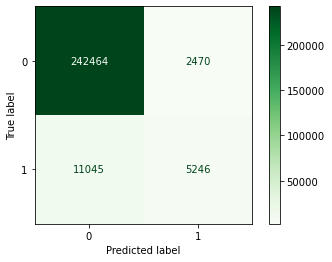

In [67]:
print(classification_report(y_test, Y_predict))

cm = confusion_matrix(y_true = y_test, y_pred = Y_predict)
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Greens)

### 3.2.3 Linear SVC

In [68]:
# Support Vector Machines

svc = LinearSVC()
svc.fit(X_train_stack, y_train)
Y_pred = svc.predict(X_test_stack)
svc_f1 = f1_score(y_test, Y_pred)
svc_f1

0.47375979647942223

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    244934
           1       0.71      0.35      0.47     16291

    accuracy                           0.95    261225
   macro avg       0.84      0.67      0.72    261225
weighted avg       0.94      0.95      0.94    261225



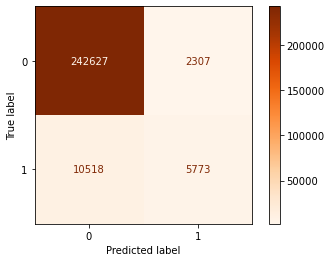

In [69]:
print(classification_report(y_test, Y_pred))

cm = confusion_matrix(y_true = y_test, y_pred = Y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Oranges)

### 3.2.4 Stochastic Gradient Descent

In [70]:
sgd = SGDClassifier(loss="log", max_iter=100)
sgd.fit(X_train_stack, y_train)
Y_pred = sgd.predict(X_test_stack)
sgd_f1 = f1_score(y_test, Y_pred)
sgd_f1

0.03357742454009644

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    244934
           1       0.56      0.02      0.03     16291

    accuracy                           0.94    261225
   macro avg       0.75      0.51      0.50    261225
weighted avg       0.91      0.94      0.91    261225



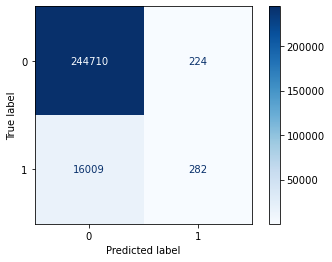

In [71]:
print(classification_report(y_test, Y_pred))

cm = confusion_matrix(y_true = y_test, y_pred = Y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Blues)

Gradient descent is not working well, it is classifing everything as '0' and since their is a imbalance it can get good f-1 score for class 0 but not for class-1. Thus before moving to Neural networks we will have to handle this imbalance between the 2 classes.

### 4. Model Evaluation of simple models

In [72]:
models = pd.DataFrame({
    'Model': [ 'Logistic Regression', 'Linear SVC', 
              'Stochastic Gradient Decent'],
    'Score': [LogisticR_f1, svc_f1, sgd_f1]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Linear SVC,0.473760
0,Logistic Regression,0.437039
2,Stochastic Gradient Decent,0.033577


## This is the second part of this project

    - Handle imbalance classes
    - Use Neural Netowrk as well as CNN
    - Use new Evaluation Matric call Matthews Corelation Coefficient with F-1 Score
    - Evaluation
    - Prediction on Test data Using best model

#### This is just to check if you have tensorflow for gpu installed to use gpu for faster processing

In [73]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


#### Since I merged my 2nd ipynb, not changing my data frame since need to change too much 

In [74]:
df_train = df_train.drop(['words_count','uniques_word_count','chars_count','numerics_count','punctuations_count', 
                          'words_count_upper', 'words_count_title', 'mean_word_len','stopword_count'],axis = 1)
df_test = df_test.drop(['words_count','uniques_word_count','chars_count','numerics_count','punctuations_count', 
                        'words_count_upper', 'words_count_title', 'mean_word_len','stopword_count'],axis = 1)

In [75]:
train_data= df_train
test_data= df_test

In [76]:
train_data.head(1)

,qid,question_text,target,preprocessed_question_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How Quebec nationalist see province nation 1960s


In [77]:
# Class count
count_class_0, count_class_1 = train_data.target.value_counts()

# Divide by class
df_class_0 = train_data[train_data['target'] == 0]
df_class_1 = train_data[train_data['target'] == 1]


## 5. Handling Imbalance of Data and applying Neural Network
### 5.1 UnderSampling

Undersampling is the method used in the case of highly inbalanced class distribution, we select less amount of data from the class with most samples. In this project, 1.2 million samples classified as 0 (sincere) and only 88,000 classified as 1 (insincere). So we will only be taking 200,000 class-0 and all of class-1 to see the performance

In [78]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(250000) # selects random samples
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

Random under-sampling:
0    250000
1     80810
Name: target, dtype: int64


In [79]:
x = df_test_under['preprocessed_question_text']
y = df_test_under['target']

#### 5.1.1 Splitting our data into train,test,validation

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    x.tolist(), 
    y.tolist(), 
    test_size=0.2,
    stratify = y.tolist(), # Stratify will produce balanced distribution of classes(Used because of imbalance)
    random_state=2019) # to get same split each time it is runs

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size=0.1,
        #stratify = train_data['target'].tolist(), # Stratify will produce balanced distribution of classes(Used because of imbalance)
        random_state=2019)

In [81]:
print('Train data length:'+str(len(X_train)))
print('Class distribution: '+str(Counter(y_train)))
print('Valid data length:'+str(len(X_valid)))
print('Class distribution: '+ str(Counter(y_valid)))

Train data length:238183
Class distribution: Counter({0: 179969, 1: 58214})
Valid data length:26465
Class distribution: Counter({0: 20031, 1: 6434})


#### 5.1.2 Converting these datasets into tensors to fed into out models

In [82]:
# To process text we need to convert them to numpy array

x_train = np.asarray(X_train)
x_valid = np.array(X_valid)
x_test = np.asarray(X_test)
test_array = np.asarray(test_data['preprocessed_question_text'].tolist())

test_values = np.asarray
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

# Creating tensors dataframe by combining questions with label(target in our case)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

#### 5.1.2.2 Visualize the labels

In [83]:
print(y_train[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(y_train))
print('Number to category')
print(train_labels[:10])

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Number to category
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


SO label 0 is converted to [1, 0] and 1 is converted to [0, 1]

#### 5.1.3 Defining the Embedding layer for our models

We are using pre trained layers from google "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1" as our embedding layer but we have given trainable = True so that it can learn from our data as well

In [84]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, 
                           trainable=True # This mean we can train these pretrained neurons with our data as well
                          )

#### 5.1.3.1 Visualize how embedding layer will change our data

In [85]:
# Lets see how this embedding layer is changing our text data
print(x_train[:1])
hub_layer(x_train[:1])

['Why rich liberal feminist think superior smarter non feminist woman']


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 2.6632464 , -0.75729585,  2.3448822 , -1.1172974 , -1.2611843 ,
        -0.7694547 ,  0.2230481 ,  1.538102  ,  2.4287105 , -0.23303764,
         0.9281222 , -1.179939  , -0.6205544 ,  0.2944729 , -1.6747212 ,
        -1.2981721 ,  1.847325  , -0.52794915, -1.8897237 , -1.0263611 ]],
      dtype=float32)>

#### 5.1.4 Creating basic neural network with activation function relu

Please check the report for better understanding of Neural Networks

In [86]:
model = tf.keras.Sequential()
model.add(hub_layer) # Defined above
model.add(tf.keras.layers.Dense(16, activation='relu')) # Hidden layers and fully connected 
model.add(tf.keras.layers.Dense(2,activation='relu')) # Number of neurons at the end is 2 because we have binary classification problem


model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam', # optimizing the weight we use adam optimizer during backpropogation
              metrics=["binary_accuracy"] 
            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 389,750
Trainable params: 389,750
Non-trainable params: 0
_________________________________________________________________


In [87]:
# Fit the model using the train and test datasets.

NN_model = model.fit(train_ds.shuffle(2000).batch(125), # Shuffling the data before giving it to model for training
                    epochs= 35 , # Number of times the model will train on the data
                    validation_data=valid_ds.batch(125),
                    verbose=1)

Epoch 1/35
1906/1906 [==============================] - 14s 7ms/step - loss: 1.2464 - binary_accuracy: 0.7484 - val_loss: 0.6422 - val_binary_accuracy: 0.7919
Epoch 2/35
1906/1906 [==============================] - 12s 6ms/step - loss: 0.5034 - binary_accuracy: 0.8250 - val_loss: 0.4389 - val_binary_accuracy: 0.8434
Epoch 3/35
1906/1906 [==============================] - 13s 7ms/step - loss: 0.4207 - binary_accuracy: 0.8490 - val_loss: 0.4041 - val_binary_accuracy: 0.8546
Epoch 4/35
1906/1906 [==============================] - 12s 6ms/step - loss: 0.3768 - binary_accuracy: 0.8643 - val_loss: 0.3673 - val_binary_accuracy: 0.8710
Epoch 5/35
1906/1906 [==============================] - 12s 6ms/step - loss: 0.3452 - binary_accuracy: 0.8775 - val_loss: 0.3798 - val_binary_accuracy: 0.8690
Epoch 6/35
1906/1906 [==============================] - 12s 7ms/step - loss: 0.3299 - binary_accuracy: 0.8831 - val_loss: 0.3584 - val_binary_accuracy: 0.8811
Epoch 7/35
1906/1906 [========================

#### 5.1.5 Visualizing how loss function and binary_accuracy metric are doing in each epochs for train and validation data

In [88]:
def loss_plot(loss, val_loss):
    
    # Plot between loss function and no of epochs
    plt.plot(loss, label='training data')
    plt.plot(val_loss, label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Binary Crossentropy Loss Function')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

def val_plot(acc, bin_acc):
    # plot between Binary Accuracy and no. of epochs
    plt.plot(acc, label=' training data')
    plt.plot(bin_acc, label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

#### Graphs might be a little different than in ppt, since before submitting the code I re-ran whole ipynb to make sure everything was working.

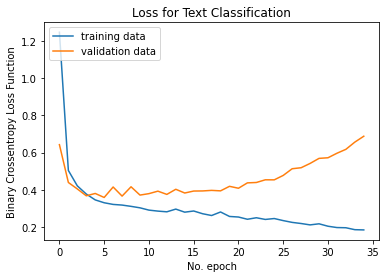

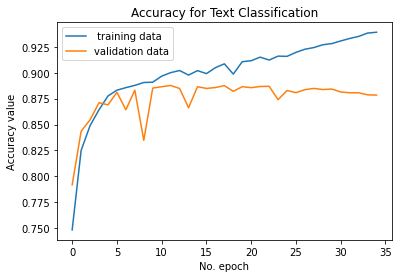

In [89]:
history = model.history

loss_plot(history.history['loss'], history.history['val_loss'])
val_plot(history.history['binary_accuracy'], history.history['val_binary_accuracy'])

__Observations:__
- This model is still overfitting on training data since there is still a imbalance between class-0 and class-1 in the ratio 3.2:1
- Also it might be because train and validation data are in 9:1 ratio and thus lets say validation has 5 data and train has 45 data and in both 1 is predicted incorrectly, then accuracy of validation will be affected more than the train accuracy.

But due to time constraint I'm just focusing on 1st point. 

#### 5.1.6 Evaluating on test split 

In [90]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test,test_labels)
print("test loss, test acc:", results)


# Generate predictions 
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Evaluate on test data
2068/2068 [==============================] - 8s 4ms/step - loss: 0.6557 - binary_accuracy: 0.8814
test loss, test acc: [0.6557250618934631, 0.881434977054596]
Generate predictions for all samples
[[1.9735342  0.        ]
 [0.6321464  0.3236721 ]
 [0.8738417  0.14938809]
 ...
 [0.         1.3534123 ]
 [2.5058377  0.        ]
 [1.0864594  0.        ]]


In [91]:
# Creating a data frame with target values of test split and predicted values from model

testing = pd.DataFrame()
testing['predicted_model'] = predict_results
testing['target'] = y_test


              precision    recall  f1-score   support

           0       0.92      0.92      0.92     50000
           1       0.76      0.75      0.76     16162

    accuracy                           0.88     66162
   macro avg       0.84      0.84      0.84     66162
weighted avg       0.88      0.88      0.88     66162



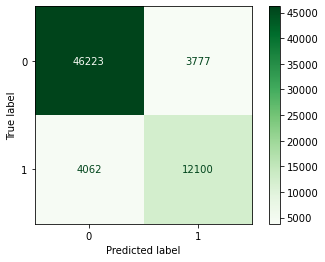

In [92]:
print(classification_report(testing['target'].tolist(), testing['predicted_model'].tolist()))

cm = confusion_matrix(y_true = testing['target'].tolist(), y_pred = testing['predicted_model'].tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Greens)

__Matthews correlation coefficient__:
- The coefficient takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.
- The MCC is in essence a correlation coefficient between the observed and predicted binary classifications; it returns a value between −1 and +1.
- A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation

https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

In [93]:
# Matthews correlation coefficient

mc = matthews_corrcoef(testing['target'].tolist(), testing['predicted_model'].tolist())
print('matthews correlation coefficient for this model is: ', mc);

matthews correlation coefficient for this model is:  0.6772170273758407


As you can see F-1 has increased a lot for class-1 so we now know that our preprocessing was good but model were performing bad due to skewed data.

### 5.2 OverSampling and UnderSampling

OverSampling is to duplicate the under-represented class i.e. class-1 to make it of almost equal size as class-0. 

We cannot just blindly do oversampling since we had 88,000 class-1 data while 1.3 million class-0 data. So we would be duplicating the records of class-1 15 times thats not good data at all to feed our models.

So Instead we would undersample class-0 to 650,000 and oversample class-1 to 320,000

In [94]:
df_class_0_sample = df_class_0.sample(650000) # Selecting random 500,000 samples

# Class count
count_class_0 = df_class_0_sample.target.value_counts()
count_class_0

0    650000
Name: target, dtype: int64

In [95]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(320000, replace=True)
df_test_over = pd.concat([df_class_0_sample, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

Random over-sampling:
0    650000
1    320000
Name: target, dtype: int64


In [96]:
x = df_test_over['preprocessed_question_text']
y = df_test_over['target']

Defined a function to do splitting as well as conversion to tensor for reusability

#### 5.2.1 Splitting and creating tensors

In [97]:
def splitting(X, Y):
    # Splitting into train/test into 80:20 ratios 
    X_train, X_test, y_train, y_test = train_test_split(
        X.tolist(), 
        Y.tolist(), 
        test_size=0.2,
        stratify = Y.tolist(), # Stratify will produce balanced distribution of classes(Used because of imbalance)
        random_state=2019)

    # From that 80% train split, Splitting again into train/validation in 90:10 ratios
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size=0.1,
        random_state=2019)
    
    # Converting these data splits into tensors to pass into neural network
    # To process text we need to convert them to numpy array
    x_train = np.asarray(X_train)
    x_valid = np.array(X_valid)
    x_test = np.asarray(X_test)

    test_values = np.asarray
    le = LabelEncoder()

    train_labels = le.fit_transform(y_train)
    train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

    valid_labels = le.transform(y_valid)
    valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

    test_labels = le.transform(y_test)
    test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

    # Creating tensors dataframe by combining questions with label(target in our case)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))
    
    return train_ds,valid_ds,x_test,test_labels,y_test

In [98]:
train_ds, valid_ds, x_test, test_labels, y_test = splitting(x,y)

We only initialize embedding layer once, we will just use that instance

#### 5.2.2 Using same simpe model used in UnderSampling

In [99]:
model1 = tf.keras.Sequential()
model1.add(hub_layer) # Defined above
model1.add(tf.keras.layers.Dense(16, activation='relu')) # Hidden layers and fully connected 
model1.add(tf.keras.layers.Dense(2,activation='relu')) # Number of neurons at the end is 2 because we have binary classification problem


model1.summary()
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam', # optimizing the weight we use adam optimizer during backpropogation
              metrics=["binary_accuracy"] 
            )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 389,750
Trainable params: 389,750
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Fit the model using the train and test datasets.

NN_model1 = model1.fit(train_ds.shuffle(2000).batch(125), # Shuffling the data before giving it to model for training
                    epochs= 35 , # Number of times the model will train on the data
                    validation_data=valid_ds.batch(125),
                    verbose=1)

Epoch 1/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.2603 - binary_accuracy: 0.8567 - val_loss: 0.2381 - val_binary_accuracy: 0.8588
Epoch 2/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.2260 - binary_accuracy: 0.8679 - val_loss: 0.2263 - val_binary_accuracy: 0.8630
Epoch 3/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.2082 - binary_accuracy: 0.8774 - val_loss: 0.2179 - val_binary_accuracy: 0.8676
Epoch 4/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.1944 - binary_accuracy: 0.8856 - val_loss: 0.2124 - val_binary_accuracy: 0.8726
Epoch 5/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.1829 - binary_accuracy: 0.8904 - val_loss: 0.2078 - val_binary_accuracy: 0.8747
Epoch 6/35
5588/5588 [==============================] - 33s 6ms/step - loss: 0.1731 - binary_accuracy: 0.8930 - val_loss: 0.2041 - val_binary_accuracy: 0.8714
Epoch 7/35
5588/5588 [========================

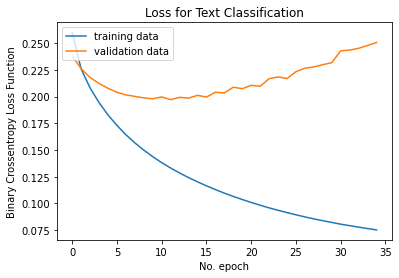

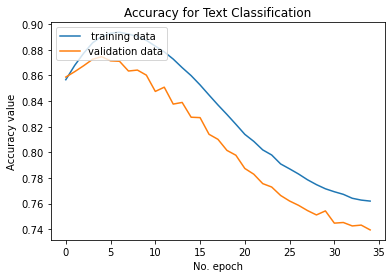

In [101]:
history1 = model1.history
loss_plot(history1.history['loss'], history1.history['val_loss'])
val_plot(history1.history['binary_accuracy'], history1.history['val_binary_accuracy'])

This split between the 2 curves can be because this NN can't handle the amount of data that is being fed for training. Since there is only 1 dense layer and also with only 16 neurons. So it can't separate good features from average ones.

#### 5.2.3 Evaluating on test split 

In [102]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(x_test,test_labels)
print("test loss, test acc:", results)


# Generate predictions 
print("Generate predictions for all samples")
prediction1 = model1.predict(x_test)
print(prediction1)
predict_result1 = prediction1.argmax(axis=1)

# Creating a data frame with target values of test split and predicted values from model

testing = pd.DataFrame()
testing['predicted_model'] = predict_result1
testing['target'] = y_test

Evaluate on test data
6063/6063 [==============================] - 24s 4ms/step - loss: 0.2528 - binary_accuracy: 0.7391
test loss, test acc: [0.25276240706443787, 0.73912113904953]
Generate predictions for all samples
[[65.95747   13.017104 ]
 [24.121967   6.880102 ]
 [41.46033    4.450248 ]
 ...
 [ 2.8281617  0.       ]
 [ 4.104179  13.792855 ]
 [30.309065   2.8588655]]


              precision    recall  f1-score   support

           0       0.97      0.93      0.95    130000
           1       0.87      0.94      0.91     64000

    accuracy                           0.94    194000
   macro avg       0.92      0.94      0.93    194000
weighted avg       0.94      0.94      0.94    194000



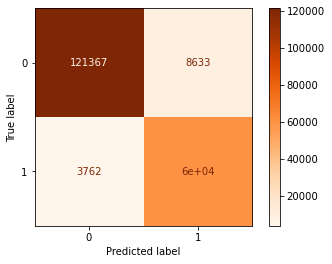

In [103]:
print(classification_report(testing['target'].tolist(), testing['predicted_model'].tolist()))

cm = confusion_matrix(y_true = testing['target'].tolist(), y_pred = testing['predicted_model'].tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Oranges)

Checking Matthews correlation as well

In [104]:
# Matthews correlation coefficient

mc1 = matthews_corrcoef(testing['target'].tolist(), testing['predicted_model'].tolist())
print('matthews correlation coefficient for this model is: ', mc1);

matthews correlation coefficient for this model is:  0.8595650440064555


#### As we can see from these results, 2nd method is working way better than the first one, we have 2 choices
1) To keep on experimenting with Classes Size (over/underfitting) or check other libraries online

2) Experiment with hyper paramters of neural network and layers 

Due to time constraint I'm going to do step-2

#### 5.2.4 Using Deeper & wider neural network

In [105]:
model2 = tf.keras.Sequential()
# Input Layer
model2.add(hub_layer) 
model2.add(tf.keras.layers.Dense(32, activation='relu')) # Hidden layers and fully connected 
model2.add(tf.keras.layers.Dense(16, activation='relu')) 
model2.add(tf.keras.layers.Dense(2,activation='relu')) # Number of neurons at the end is 2 because we have binary classification problem

model2.summary()
model2.compile(loss='binary_crossentropy', # Used because of categorical data
              optimizer='adam', # optimizing the weight we use adam optimizer during backpropogation
              metrics=["binary_accuracy"] 
            )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                672       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 390,614
Trainable params: 390,614
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Fit the model using the train and test datasets.

NN_model2 = model2.fit(train_ds.shuffle(2000).batch(125), # Shuffling the data before giving it to model for training
                    epochs= 30 , # Number of times the model will train on the data
                    validation_data=valid_ds.batch(125),
                    verbose=1)

Epoch 1/30
5588/5588 [==============================] - 38s 7ms/step - loss: 0.3935 - binary_accuracy: 0.8682 - val_loss: 0.3384 - val_binary_accuracy: 0.8889
Epoch 2/30
5588/5588 [==============================] - 38s 7ms/step - loss: 0.3267 - binary_accuracy: 0.8884 - val_loss: 0.3457 - val_binary_accuracy: 0.8637
Epoch 3/30
5588/5588 [==============================] - 38s 7ms/step - loss: 0.2816 - binary_accuracy: 0.9048 - val_loss: 0.3037 - val_binary_accuracy: 0.9003
Epoch 4/30
5588/5588 [==============================] - 38s 7ms/step - loss: 0.2458 - binary_accuracy: 0.9179 - val_loss: 0.3028 - val_binary_accuracy: 0.9114
Epoch 5/30
5588/5588 [==============================] - 38s 7ms/step - loss: 0.2296 - binary_accuracy: 0.9242 - val_loss: 0.2964 - val_binary_accuracy: 0.9111
Epoch 6/30
5588/5588 [==============================] - 37s 7ms/step - loss: 0.2300 - binary_accuracy: 0.9236 - val_loss: 0.2968 - val_binary_accuracy: 0.9157
Epoch 7/30
5588/5588 [========================

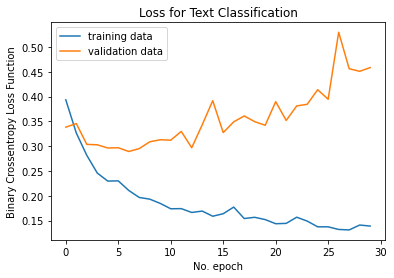

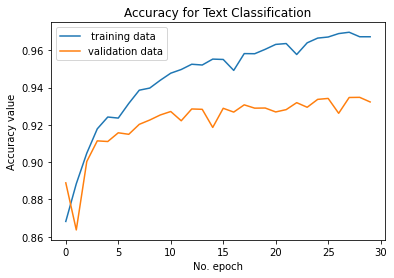

In [107]:
history2 = model2.history
loss_plot(history2.history['loss'], history2.history['val_loss'])
val_plot(history2.history['binary_accuracy'], history2.history['val_binary_accuracy'])

Even now this is overfitting on training data, so we need to use dropout layers to regularize the outcomes. Since graphs are diverging from each other.

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    130000
           1       0.85      0.95      0.90     64000

    accuracy                           0.93    194000
   macro avg       0.91      0.94      0.92    194000
weighted avg       0.94      0.93      0.93    194000



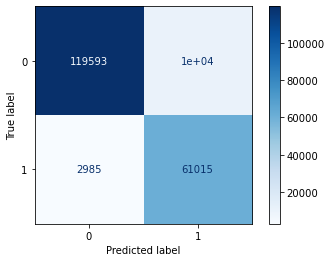

In [108]:
# Predicting on test split
prediction2 = model2.predict(x_test)
predict_result2 = prediction2.argmax(axis=1)

# Adding that prediction to data frame
testing['predicted_model1'] = predict_result2

# Printing corelation matrix
print(classification_report(testing['target'].tolist(), testing['predicted_model1'].tolist()))

cm = confusion_matrix(y_true = testing['target'].tolist(), y_pred = testing['predicted_model1'].tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Blues)

In [109]:
# Matthews correlation coefficient

mc2 = matthews_corrcoef(testing['target'].tolist(), testing['predicted_model1'].tolist())
print('matthews correlation coefficient for this model is: ', mc2);

matthews correlation coefficient for this model is:  0.8513450271346621


Still Matthews correlation coefficient is not increasing, so lets add some dropout layers to the mix

#### 5.2.5 Adding dropout layers

Dropout layers randomly assigns 0 to few percent of neurons in the network based argument passed while creating the layer. But it doesn't assign 0 while testing, thus accuracy of training decreases and validation/test increases. So this solves Overfitting probelm.

In [110]:
model3 = tf.keras.Sequential()
# Input layer
model3.add(hub_layer)

model3.add(tf.keras.layers.Dropout(0.3))
# First hidden dense layer- 32 neurons
model3.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.05)))

model3.add(tf.keras.layers.Dropout(0.2))
# First hidden dense layer- 32 neurons
model3.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.05)))

model3.add(tf.keras.layers.Dropout(0.3))
# Output layer
model3.add(tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=regularizers.l2(0.05)))

model3.summary()
model3.compile(loss='binary_crossentropy', # Used because of binary classification problem
              optimizer='adam', # optimizing the weight we use adam optimizer during backpropogation
              metrics=["binary_accuracy"] 
            )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

In [111]:
# Fit the model using the train and valid datasets.

NN_model3 = model3.fit(train_ds.shuffle(1000).batch(128),
                    epochs= 35 ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/35
5457/5457 [==============================] - 46s 8ms/step - loss: 1.5739 - binary_accuracy: 0.7892 - val_loss: 0.5868 - val_binary_accuracy: 0.8554
Epoch 2/35
5457/5457 [==============================] - 45s 8ms/step - loss: 0.5093 - binary_accuracy: 0.8465 - val_loss: 0.3860 - val_binary_accuracy: 0.8819
Epoch 3/35
5457/5457 [==============================] - 44s 8ms/step - loss: 0.4295 - binary_accuracy: 0.8653 - val_loss: 0.3985 - val_binary_accuracy: 0.8825
Epoch 4/35
5457/5457 [==============================] - 46s 8ms/step - loss: 0.4214 - binary_accuracy: 0.8721 - val_loss: 0.3733 - val_binary_accuracy: 0.8849
Epoch 5/35
5457/5457 [==============================] - 45s 8ms/step - loss: 0.4103 - binary_accuracy: 0.8737 - val_loss: 0.3584 - val_binary_accuracy: 0.8854
Epoch 6/35
5457/5457 [==============================] - 46s 8ms/step - loss: 0.4008 - binary_accuracy: 0.8782 - val_loss: 0.3456 - val_binary_accuracy: 0.8869
Epoch 7/35
5457/5457 [========================

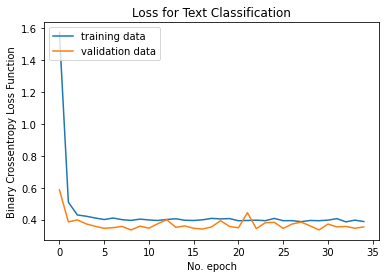

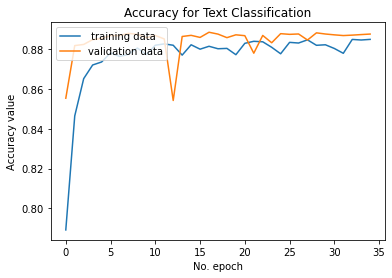

In [112]:
history3 = model3.history
loss_plot(history3.history['loss'], history3.history['val_loss'])
val_plot(history3.history['binary_accuracy'], history3.history['val_binary_accuracy'])

The oscillation in above graphs is due to dropout layer. But model is not overfitting and validation accuracy is more because in drop out layers, during training a percentage of features are set to zero. During testing, all neurons are used, thus model is more robust during testing and gives higher testing accuracies.

              precision    recall  f1-score   support

           0       0.92      0.91      0.91    130000
           1       0.82      0.84      0.83     64000

    accuracy                           0.89    194000
   macro avg       0.87      0.87      0.87    194000
weighted avg       0.89      0.89      0.89    194000



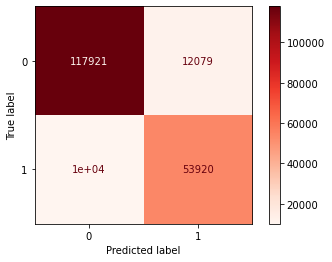

In [113]:
# Predicting on test split
prediction3 = model3.predict(x_test)
predict_result3 = prediction3.argmax(axis=1)

# Adding that prediction to data frame
testing['predicted_model2'] = predict_result3

# Printing corelation matrix
print(classification_report(testing['target'].tolist(), testing['predicted_model2'].tolist()))

cm = confusion_matrix(y_true = testing['target'].tolist(), y_pred = testing['predicted_model2'].tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Reds)

In [114]:
# Matthews correlation coefficient

mc3 = matthews_corrcoef(testing['target'].tolist(), testing['predicted_model2'].tolist())
print('matthews correlation coefficient for this model is: ', mc3);

matthews correlation coefficient for this model is:  0.7438869991701518


Even though MCC is lower than previous model it is not overfitting on the data as we can see from the Graphs

## 6. Convolution Neural Network

Now lets use CNN to improve MCC, using under/oversampling just like before. Check report to understand CNN better.

### 6.1 Converting the data into tokens using tokenizer

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

In [115]:
train_ls = train_data['preprocessed_question_text'].tolist()
train_ar = np.asarray(train_ls)

# Creating our vocab on whole data
num_words = 750000 # These are the top words from train data to be fed into tokenizer function

tokenizer = Tokenizer(num_words=num_words,oov_token="unk") # If a word is out of vocabulary then we instantiate them as unknow-"unk"
tokenizer.fit_on_texts(train_ar)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[13916, 4, 21, 891]]


In [116]:
# Function to split the data and converting into tokens to be passed in cnn
def tokens_cnn(X, Y):
    # Splitting into train/test into 80:20 ratios 
    X_train, X_test, y_train, y_test = train_test_split(
        X.tolist(), 
        Y.tolist(), 
        test_size=0.2,
        stratify = Y.tolist(), # Stratify will produce balanced distribution of classes(Used because of imbalance)
        random_state=2019)

    # From that 80% train split, Splitting again into train/validation in 90:10 ratios
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, 
        y_train, 
        test_size=0.1,
        random_state=2019)
    
    # Converting these data splits into tensors to pass into neural network
    X_train_ar = np.array(X_train)
    X_test_ar = np.array(X_test)
    X_valid_ar = np.array(X_valid)

    x_train = np.array( tokenizer.texts_to_sequences(X_train_ar) )
    x_valid = np.array( tokenizer.texts_to_sequences(X_valid_ar) )
    x_test  = np.array( tokenizer.texts_to_sequences(X_test_ar) )

    x_train = pad_sequences(x_train, padding='post', maxlen=87) # Add padding till length is 87 and add padding after the data 
    x_valid = pad_sequences(x_valid, padding='post', maxlen=87)
    x_test = pad_sequences(x_test, padding='post', maxlen=87)

    print(x_train[4])

    le = LabelEncoder()

    train_labels = le.fit_transform(y_train)
    train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

    valid_labels = le.transform(y_valid)
    valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

    test_labels = le.transform(y_test)
    test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))
    
    return train_ds,valid_ds,x_test,test_labels,y_test

In [117]:
train_ds, valid_ds, x_test, test_labels, y_test = tokens_cnn(x,y)

[ 167  857   43    7 5270   79  425 1731 9302  865 4493 3859  865    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


### 6.2 CNN Model Creation

In [118]:
max_features = 750000 # Number of unique words we passed to tokenizer to train and convert our data into tokens
embedding_dim =64
sequence_length = 87 # Size of our tensor/tokens

# Input layer, embedding layer
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

# 1 dimensional Convolution layer
model4.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model4.add(tf.keras.layers.GlobalMaxPooling1D())
# Hidden dense layer-32 neurons

model4.add(tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
# Hidden dense layer-16 neurons
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
# output layer
model4.add(tf.keras.layers.Dense(2, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model4.summary()
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=["binary_accuracy"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 87, 64)            48000064  
_________________________________________________________________
conv1d (Conv1D)              (None, 85, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                

In [119]:

# Fit the model using the train and test datasets.

model_cnn = model4.fit(train_ds.shuffle(2000).batch(128),
                    epochs= 30 ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/30
5457/5457 [==============================] - 152s 27ms/step - loss: 0.6919 - binary_accuracy: 0.8448 - val_loss: 0.4226 - val_binary_accuracy: 0.8807
Epoch 2/30
5457/5457 [==============================] - 145s 27ms/step - loss: 0.4350 - binary_accuracy: 0.8775 - val_loss: 0.4012 - val_binary_accuracy: 0.8839
Epoch 3/30
5457/5457 [==============================] - 147s 27ms/step - loss: 0.4113 - binary_accuracy: 0.8809 - val_loss: 0.3788 - val_binary_accuracy: 0.8884
Epoch 4/30
5457/5457 [==============================] - 146s 27ms/step - loss: 0.4136 - binary_accuracy: 0.8836 - val_loss: 0.3890 - val_binary_accuracy: 0.8894
Epoch 5/30
5457/5457 [==============================] - 145s 27ms/step - loss: 0.3972 - binary_accuracy: 0.8876 - val_loss: 0.3699 - val_binary_accuracy: 0.8929
Epoch 6/30
5457/5457 [==============================] - 146s 27ms/step - loss: 0.3877 - binary_accuracy: 0.8897 - val_loss: 0.3674 - val_binary_accuracy: 0.8939
Epoch 7/30
5457/5457 [============

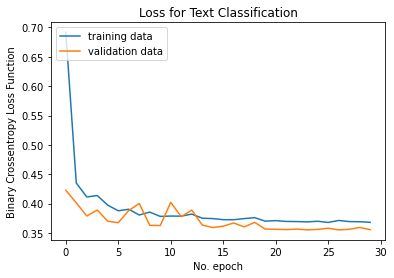

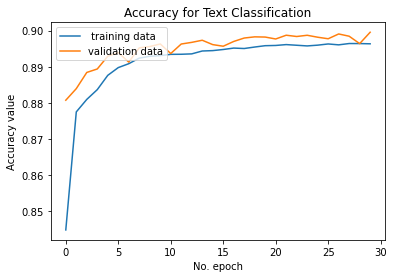

In [120]:
history4 = model4.history
loss_plot(history4.history['loss'], history4.history['val_loss'])
val_plot(history4.history['binary_accuracy'], history4.history['val_binary_accuracy'])

              precision    recall  f1-score   support

           0       0.93      0.92      0.92    130000
           1       0.84      0.85      0.85     64000

    accuracy                           0.90    194000
   macro avg       0.88      0.89      0.89    194000
weighted avg       0.90      0.90      0.90    194000



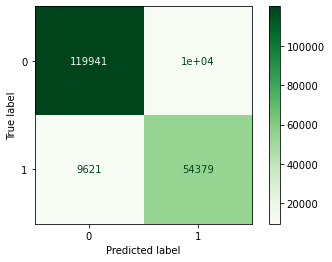

In [121]:
# Predicting on test split
prediction4 = model4.predict(x_test)
predict_result4 = prediction4.argmax(axis=1)

# Adding that prediction to data frame
testing['predicted_model3'] = predict_result4

# Printing corelation matrix
print(classification_report(testing['target'].tolist(), testing['predicted_model3'].tolist()))

cm = confusion_matrix(y_true = testing['target'].tolist(), y_pred = testing['predicted_model3'].tolist())
cmp = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmp.plot(cmap=plt.cm.Greens)

In [122]:
# Matthews correlation coefficient

mc4 = matthews_corrcoef(testing['target'].tolist(), testing['predicted_model3'].tolist())
print('matthews correlation coefficient for this model is: ', mc4);

matthews correlation coefficient for this model is:  0.7709656190646821


## 7. Evaluation of Neural Networks and CNN

In [123]:
models_mcc = pd.DataFrame({
    'Models': [ 'UnderSampling and Simple NN', 'Over/UnderSampling and Simple NN', 
              'Deeper Neural Network', 'Adding dropour layers' , 'CNN'],
    'Matthew Correlation Coefficient': [mc, mc1, mc2, mc3, mc4]})
models_mcc.sort_values(by='Matthew Correlation Coefficient', ascending=False)

,Models,Matthew Correlation Coefficient
1,Over/UnderSampling and Simple NN,0.859565
2,Deeper Neural Network,0.851345
4,CNN,0.770966
3,Adding dropour layers,0.743887
0,UnderSampling and Simple NN,0.677217


__Observations:__
- Using hybrid method of Oversampling and Undersampling is the better move, since we don't give up on too much of data nor we duplicate the same data too many times
- Due to use of dropout layers we are dropping some features, this might be the case for lower MCC for CNN and model-3
- Now to Increase the MCC, I think we can either play around with more hyper parameter tuning for Neural Networks as well as CNN.
- Or we can try more methods to handle imbalance classes. There are few online libraries available to use or can explore more with hybrid method like changing the ratios of over/under sampling.
- Now from graphs as well as MCC we can safely say that using model-3 with dropout layers or CNN is the best use right now. Thus below is the predictions on Test data

## 8. Predictions on Test data Using model-3

In [124]:
test_array = np.asarray(test_data['preprocessed_question_text'].tolist())

In [125]:
print("Generate predictions for all samples")
predictions = model3.predict(test_array)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.18133268 0.7672907 ]
 [1.2429478  0.        ]
 [1.0419023  0.        ]
 ...
 [1.1283238  0.        ]
 [1.0743668  0.        ]
 [1.0629776  0.        ]]


In [126]:
test_data['target']= predict_results

sinc_num = len(test_data.question_text[test_data['target'] == 0]),'sincere questions'
insinc_num= len(test_data.question_text[test_data['target'] == 1]),'unsincere questions'

print(sinc_num)
print(insinc_num)


(323886, 'sincere questions')
(51920, 'unsincere questions')


In [127]:
print(test_data.question_text[test_data['target'] == 1])

0         Why do so many women become so rude and arroga...
13             Why my answers not get any upvotes on Quora?
16        Why is it that Trump supporters see him as a d...
21        Why do so many people on this damn site not ac...
27        Let's say that hypothetically the alt-right ni...
                                ...                        
375785    Why can’t some people laugh out loud at anything?
375786    Why do fathers who have antisocial personality...
375788    Why is it only men with guns go on shooting ra...
375794    Why are Mexican people always in relationships...
375799    Why do all the stupid people I know tend to be...
Name: question_text, Length: 51920, dtype: object


In [128]:
print(test_data.question_text[test_data['target'] == 0])

1         When should I apply for RV college of engineer...
2         What is it really like to be a nurse practitio...
3                                    Who are entrepreneurs?
4          Is education really making good people nowadays?
5               How do you train a pigeon to send messages?
                                ...                        
375801    How many countries listed in gold import in in...
375802    Is there an alternative to dresses on formal p...
375803    Where I can find best friendship quotes in Tel...
375804          What are the causes of refraction of light?
375805    Climate change is a worrying topic. How much t...
Name: question_text, Length: 323886, dtype: object
